In [1]:
import wrds 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date as dt
from datetime import timedelta
from scipy import stats

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import mean_squared_error as mse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install arch

from arch import arch_model

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Types of Volatility and How They are Measured
(Source: https://www.investopedia.com/terms/v/vix.asp)

Volatility attempts to measure the magnitude of price movements that a financial instrument experiences over a certain period of time. The more dramatic the price swings are in that instrument, the higher the level of volatility, and vice versa.

“Volatility does not measure the direction of price changes, merely their dispersion. This is because when calculating standard deviation (or variance), all differences are squared, so that negative and positive differences are combined into one quantity. Two instruments with different volatilities may have the same expected return, but the instrument with higher volatility will have larger swings in values over a given period of time.” (source: Wikipedia)

Volatility can either be historical or implied; both are usually expressed in percentage terms.

Historical Volatility (HV) or Realised Volatility is the actual volatility demonstrated by the underlying over a period of time, such as the past month or year. Realised Volatility is commonly calculated as the standard deviation of price returns, which is the dollar change in price as a percentage of previous day's price.
Implied volatility (IV), on the other hand, is the level of volatility of the underlying that is implied by the current option price.

In [284]:
#connect to wrds
conn = wrds.Connection()

Enter your WRDS username [lockiemichalski]:lock96
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [285]:
#list libraries in wrds
conn.list_libraries()

['bank',
 'compbd',
 'compgd',
 'compnad',
 'compsegd',
 'blab',
 'crspa',
 'evts',
 'issm',
 'nastraq',
 'calcbnch',
 'rent',
 'taq',
 'secsamp',
 'toyo',
 'tresg',
 'trown',
 'rpna',
 'tass',
 'snl',
 'wappsamp',
 'wcai',
 'twoiqsmp',
 'wind',
 'wqa',
 'wrds_lib_internal',
 'zacks',
 'wrdsrpts',
 'aha',
 'block',
 'cboe',
 'wrdsapps_windices_new',
 'sustain',
 'ciqsamp',
 'ppubsamp',
 'public',
 'pwt',
 'repsamp',
 'sdcsamp',
 'cisdm',
 'cisdmsmp',
 'snapsamp',
 'totalq',
 'toyosamp',
 'trace',
 'trdssamp',
 'zacksamp',
 'ahasamp',
 'trsamp',
 'trucost',
 'ibeskpi',
 'aha_sample',
 'clrvt',
 'clrvtsmp',
 'rpa',
 'bvd',
 'compg',
 'comp_bank',
 'compsamp',
 'comscore',
 'etfgsamp',
 'etfg_analytics',
 'risk',
 'trws',
 'sprat',
 'compa',
 'sdc',
 'crspm',
 'crsp',
 'compdcur',
 'ciq',
 'crspq',
 'wrdsapps_link_crsp_comp_bdx',
 'cusipm',
 'dealscan',
 'etfg',
 'eureka',
 'eventus',
 'ftse',
 'ftsesamp',
 'ginsight',
 'gmi',
 'compsnap',
 'tr_ibes_guidance',
 'govpx',
 'audit_common_new

In [286]:
#interested in Compustat Global, with Security Daily
conn.list_tables(library='comp_global_daily') #so that will be table = 'g_secd'

['dd_group',
 'dd_group_xref',
 'dd_item',
 'dd_package',
 'g_chars',
 'g_co_aaudit',
 'g_co_adesind',
 'g_co_afnd1',
 'g_co_afnd2',
 'g_co_afnddc1',
 'g_co_afnddc2',
 'g_co_afntind1',
 'g_co_afntind2',
 'g_co_ainvval',
 'g_co_hgic',
 'g_co_iaudit',
 'g_co_idesind',
 'g_co_ifndq',
 'g_co_ifndsa',
 'g_co_ifndytd',
 'g_co_ifntq',
 'g_co_ifntsa',
 'g_co_ifntytd',
 'g_co_industry',
 'g_co_ipcd',
 'g_co_offtitl',
 'g_company',
 'g_currency',
 'g_ecind_desc',
 'g_ecind_mth',
 'g_exrt_dly',
 'g_exrt_mth',
 'g_funda',
 'g_funda_fncd',
 'g_fundq',
 'g_fundq_fncd',
 'g_idx_daily',
 'g_idx_index',
 'g_idx_mth',
 'g_idxcst_his',
 'g_names',
 'g_names_ix',
 'g_names_ix_cst',
 'g_namesq',
 'g_sec_adesind',
 'g_sec_adjfact',
 'g_sec_afnd',
 'g_sec_afnddc',
 'g_sec_afnt',
 'g_sec_divid',
 'g_sec_dprc',
 'g_sec_dtrt',
 'g_sec_history',
 'g_sec_idesind',
 'g_sec_ifnd',
 'g_sec_ifnt',
 'g_sec_split',
 'g_secd',
 'g_secnamesd',
 'g_security',
 'g_sedolgvkey',
 'r_accstd',
 'r_acqmeth',
 'r_auditors',
 'r_

In [287]:
data = conn.get_table(library='comp_global_daily', table = 'g_secd', obs=5)
data.columns

Index(['gvkey', 'iid', 'datadate', 'conm', 'curcdd', 'ajexdi', 'cshoc',
       'cshtrd', 'prccd', 'prchd', 'prcld', 'prcod', 'prcstd', 'qunit',
       'curcddv', 'cheqv', 'cheqvgross', 'cheqvnet', 'cheqvtm', 'div', 'divd',
       'divdgross', 'divdnet', 'divdtm', 'divgross', 'divnet', 'divrc',
       'divrcgross', 'divrcnet', 'divsp', 'divspgross', 'divspnet', 'divsptm',
       'anncdate', 'cheqvpaydate', 'divdpaydate', 'divrcpaydate',
       'divsppaydate', 'paydate', 'recorddate', 'split', 'splitf', 'trfd',
       'epf', 'exchg', 'isin', 'secstat', 'sedol', 'tpci', 'fic', 'gind',
       'gsubind', 'loc', 'monthend'],
      dtype='object')

In [463]:
qantas = conn.raw_sql("""SELECT isin, conm, datadate as date, prccd as unadj_price, 
                         (prccd/ajexdi) as adj_price, (prchd/ajexdi) as adj_high_price, (prcld/ajexdi) as adj_low_price,
                         (cshoc/1000000) as shrout_per_mil, divd as daily_cash_div, ajexdi, cshtrd as volume,
                         ((cshoc)*(prccd/ajexdi)) as mcap_comp, gind, curcdd, gvkey, sedol, divrc as roc_daily
                         FROM comp.g_secd 
                         where gvkey = '220244' 
                      """)
qantas = qantas.drop_duplicates(subset=['date'])

In [464]:
qantas['open_adj_price'] = qantas['adj_price'].shift(1)

In [465]:
qantas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6741 entries, 0 to 6752
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isin            6741 non-null   object 
 1   conm            6741 non-null   object 
 2   date            6741 non-null   object 
 3   unadj_price     6740 non-null   float64
 4   adj_price       6740 non-null   float64
 5   adj_high_price  6361 non-null   float64
 6   adj_low_price   6361 non-null   float64
 7   shrout_per_mil  6740 non-null   float64
 8   daily_cash_div  35 non-null     float64
 9   ajexdi          6740 non-null   float64
 10  volume          6573 non-null   float64
 11  mcap_comp       6740 non-null   float64
 12  gind            6741 non-null   object 
 13  curcdd          6740 non-null   object 
 14  gvkey           6741 non-null   object 
 15  sedol           6741 non-null   object 
 16  roc_daily       1 non-null      float64
 17  open_adj_price  6739 non-null   f

In [468]:
qantas.dropna(subset=['adj_high_price'],inplace=True)
qantas.dropna(subset=['volume'],inplace=True)
qantas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6360 entries, 219 to 6752
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isin            6360 non-null   object 
 1   conm            6360 non-null   object 
 2   date            6360 non-null   object 
 3   unadj_price     6360 non-null   float64
 4   adj_price       6360 non-null   float64
 5   adj_high_price  6360 non-null   float64
 6   adj_low_price   6360 non-null   float64
 7   shrout_per_mil  6360 non-null   float64
 8   daily_cash_div  33 non-null     float64
 9   ajexdi          6360 non-null   float64
 10  volume          6360 non-null   float64
 11  mcap_comp       6360 non-null   float64
 12  gind            6360 non-null   object 
 13  curcdd          6360 non-null   object 
 14  gvkey           6360 non-null   object 
 15  sedol           6360 non-null   object 
 16  roc_daily       1 non-null      float64
 17  open_adj_price  6360 non-null  

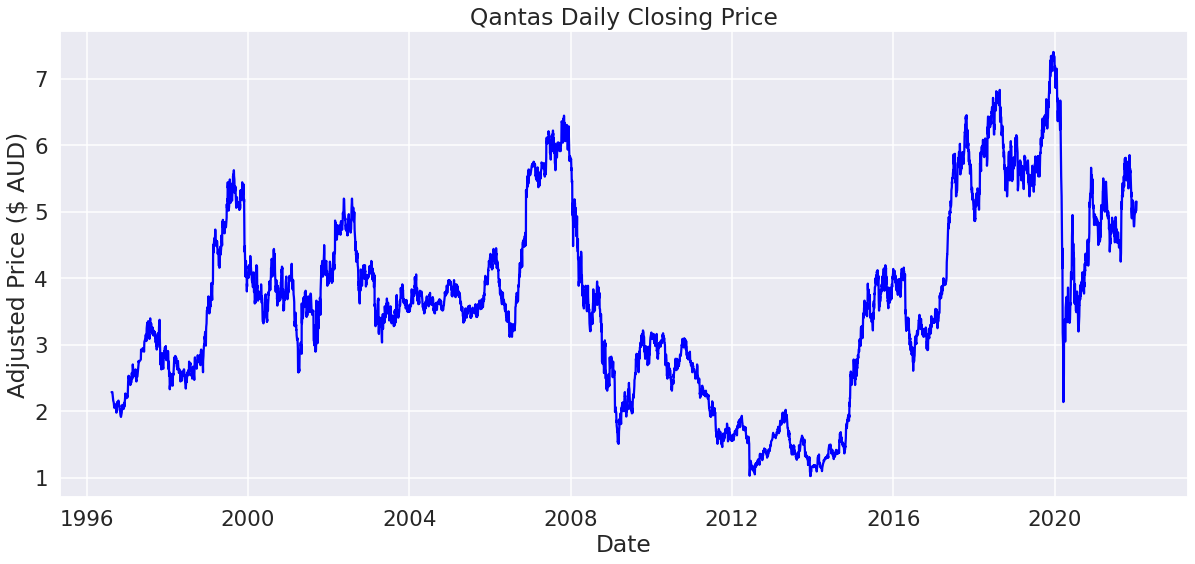

In [469]:
# DROPPING THE 1ST ROW OF DATA as NAN in price

# CHANGE CONTEXT TO poster TO INCREASE FONT SIZES
sns.set_context("talk", font_scale=1.3)

# Plot QANTAS CLOSING PRICES SINCE 1984
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.lineplot(x=qantas['date'], y=qantas['adj_price'], color='blue')
    ax.set_title('Qantas Daily Closing Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted Price ($ AUD)')


In [470]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
qantas['returns'] = 100 * qantas['adj_price'].pct_change().dropna()

# CALCULATE LOG RETURNS
qantas['log_returns'] = np.log(qantas['adj_price']/qantas['adj_price'].shift(1))

# DROP 1ST and 2ND ROW OF DATA AS USED TO CALCULATE RETURNS/LOG RETURNS
qantas = qantas.iloc[2:]
qantas[['conm','date', 'adj_price','returns', 'log_returns']]

conm        date  adj_price   returns  log_returns
224   QANTAS AIRWAYS LTD  1996-08-20   2.289670  0.000000     0.000000
230   QANTAS AIRWAYS LTD  1996-08-28   2.161874 -5.581395    -0.057432
233   QANTAS AIRWAYS LTD  1996-09-02   2.129925 -1.477833    -0.014889
234   QANTAS AIRWAYS LTD  1996-09-03   2.108626 -1.000000    -0.010050
235   QANTAS AIRWAYS LTD  1996-09-04   2.066028 -2.020202    -0.020409
...                  ...         ...        ...       ...          ...
6748  QANTAS AIRWAYS LTD  2022-01-05   5.100000 -0.970874    -0.009756
6749  QANTAS AIRWAYS LTD  2022-01-06   5.010000 -1.764706    -0.017805
6750  QANTAS AIRWAYS LTD  2022-01-07   5.030000  0.399202     0.003984
6751  QANTAS AIRWAYS LTD  2022-01-10   5.110000  1.590457     0.015779
6752  QANTAS AIRWAYS LTD  2022-01-11   5.150000  0.782779     0.007797

[6358 rows x 5 columns]

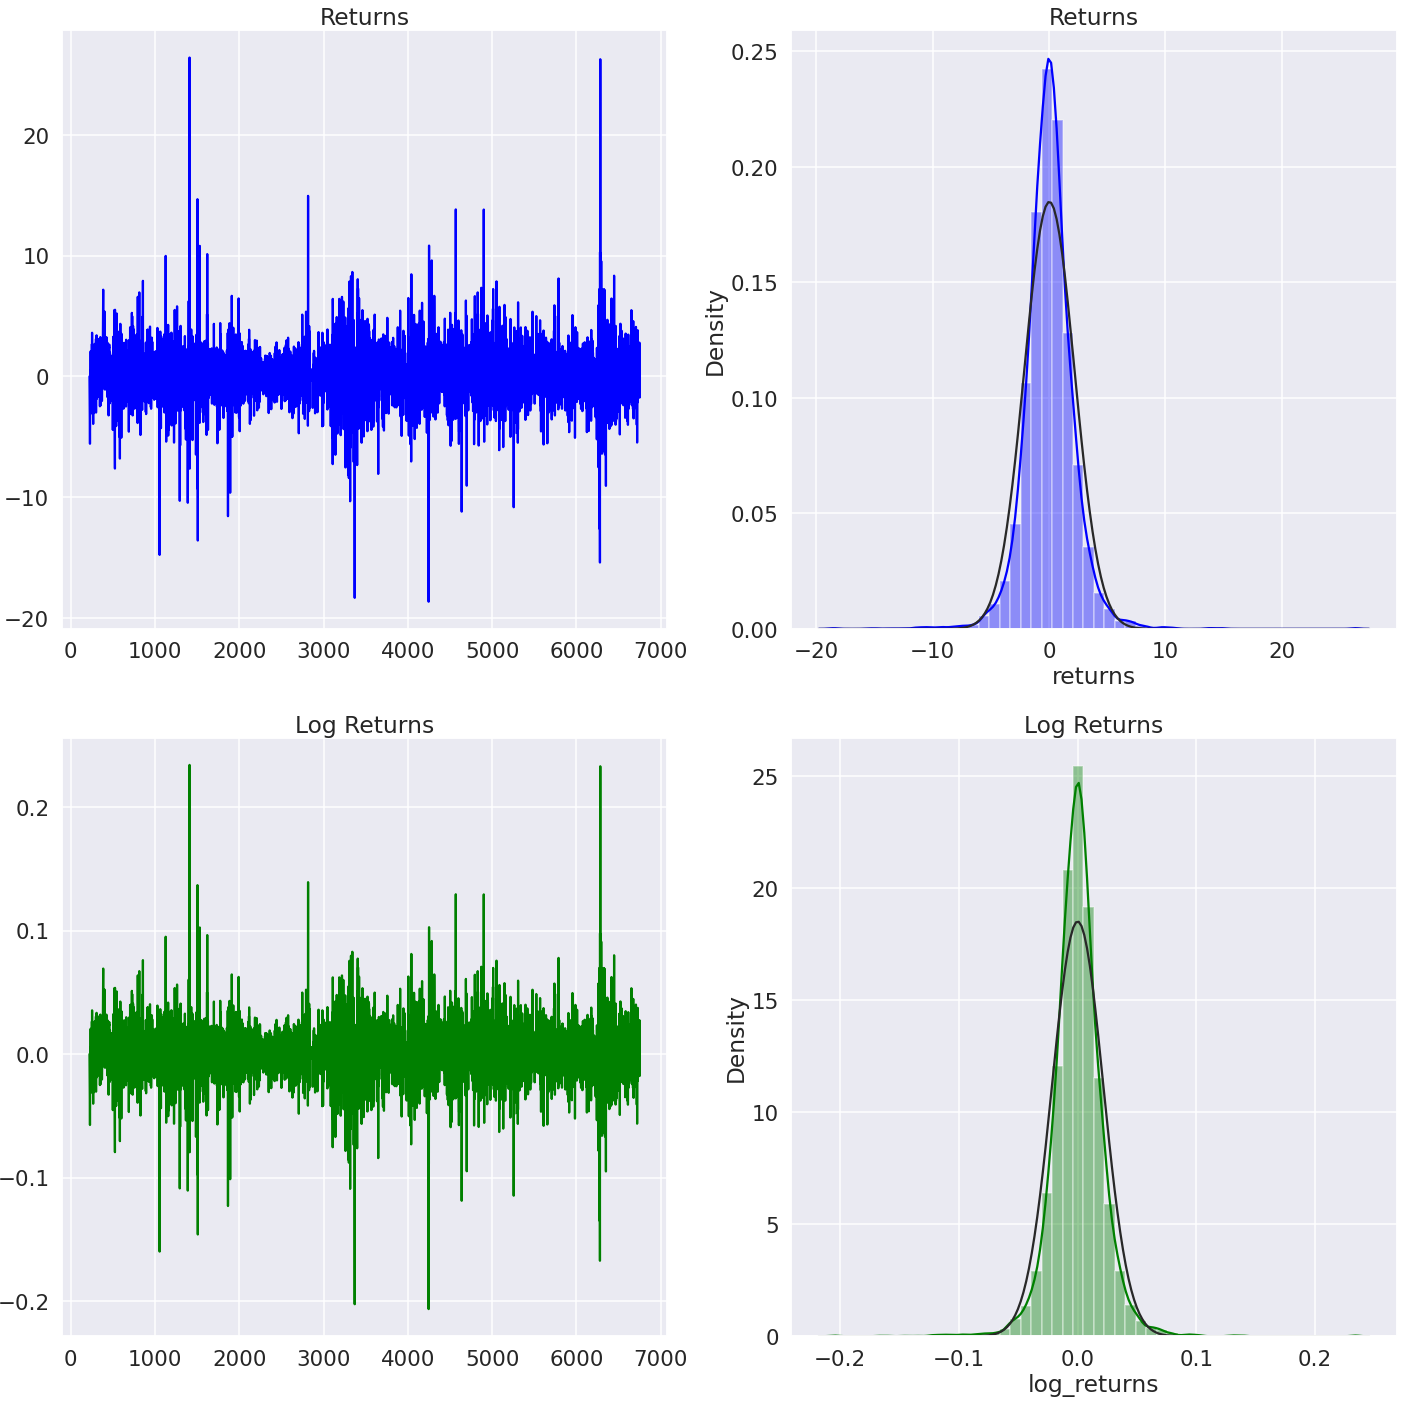

In [471]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

    axes[0][0].plot(qantas['returns'], color='blue')
    axes[0][0].set_title('Returns')

    sns.distplot(qantas['returns'], norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Returns')

    axes[1][0].plot(qantas['log_returns'], color='green')
    axes[1][0].set_title('Log Returns')

    sns.distplot(qantas['log_returns'], norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Log Returns')
    plt.tight_layout()
    fig.show();

In [472]:
qantas['returns'].describe()

count    6358.000000
mean        0.035968
std         2.157562
min       -18.661972
25%        -1.109277
50%         0.000000
75%         1.102941
max        26.394052
Name: returns, dtype: float64

In [473]:
qantas['log_returns'].describe()

count    6358.000000
mean        0.000127
std         0.021549
min        -0.206557
25%        -0.011155
50%         0.000000
75%         0.010969
max         0.234234
Name: log_returns, dtype: float64

In [474]:
# CREATE A FUNCTION THAT CALCULATE REALISED VOLATILITY
# FROM DAILY LOG RETURNS
def realised_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

# Interval Window Selection

For this specific project I'll use an interval window of 20 days (equivalent to roughly 1 month of trading for equities). The goal here is to forecast the average realized volatility of the next `n_future` 5 days using all previous available datapoint with GARCH models (expanding window forecasting), and using a number of immediate past/historical datapoints (`n_past`) with Neural Networks (sliding window forecasting).

In [475]:
intervals = [5, 20, 40, 120, 252]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = qantas['log_returns'].rolling(window=i)\
                         .apply(realised_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=qantas['date'])

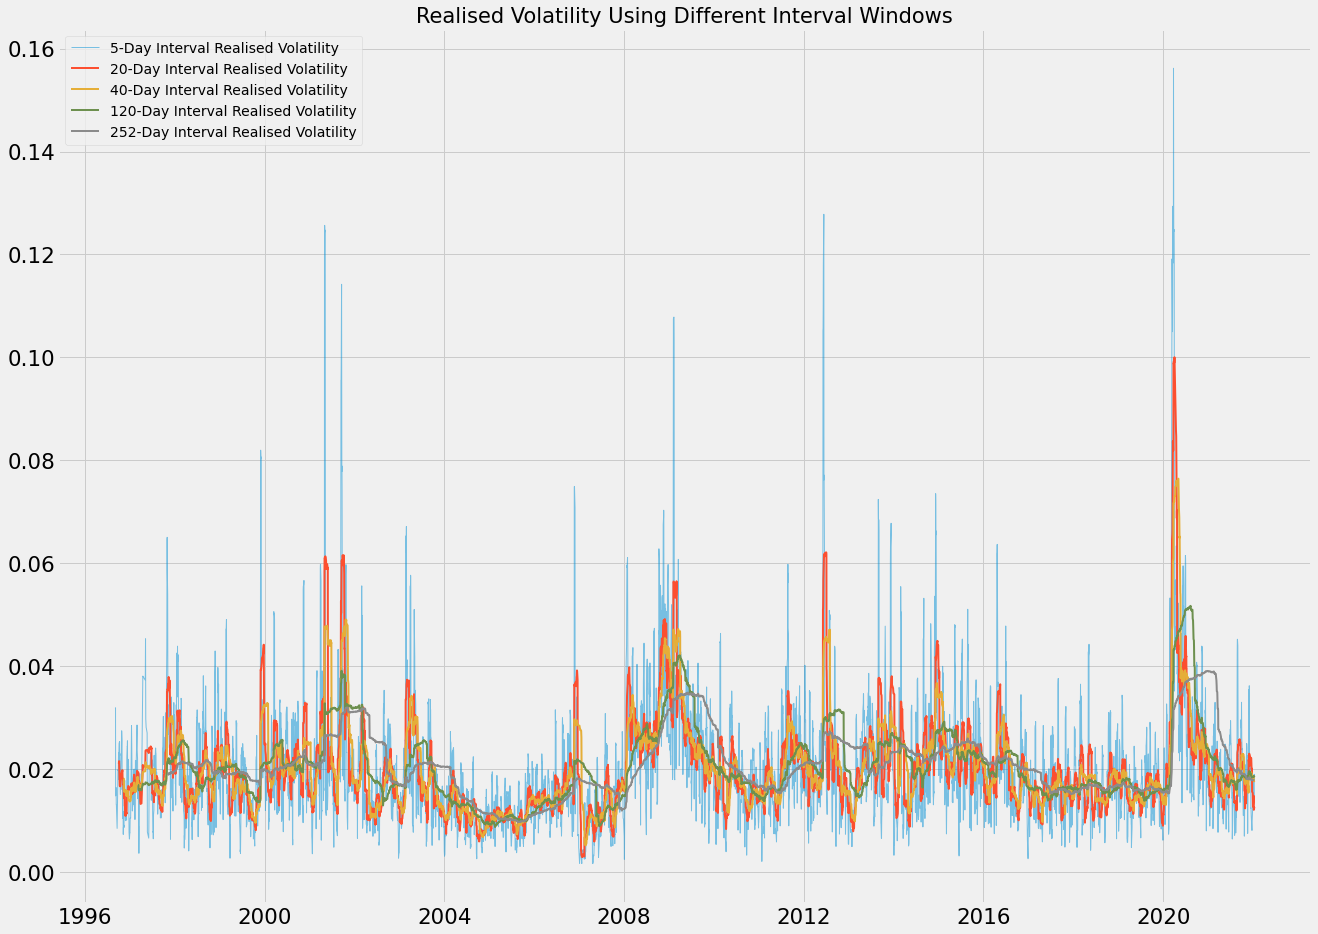

In [476]:
# CHANGING MATPLOTLIB STYLE
plt.style.use(['fivethirtyeight'])

fig, ax = plt.subplots(figsize=(20,15))

for i in intervals:
    if i == 5:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Day Interval Realised Volatility', 
            alpha=alpha, lw=lw)

ax.set_title('Realised Volatility Using Different Interval Windows', fontsize=21)

plt.legend(loc='best', prop={'size': 14})
plt.show();

The reason I selected 20 days is because 5 days seems too noisy to observe meaningful patterns, while longer intervals seem to smooth the volatility down significantly and tend to revert back to the mean.

Using interval window of 20 days would also help avoid wasting too many datapoints at the beginning of the dataset.

Time-series forecasting models are the models that are capable to predict future values based on previously observed values. Target "future" data in this case is obtained by shifting the current volatility backward by the number of n_future lags.

For example, respected to last week's Monday, this week's Monday is the "future"; therefore I just need to shift the volatility this week back by 5 days, and use it as the desired "future" output for last week's, which I would then use for Neural Networks training and model performance evaluation.

In [477]:
INTERVAL_WINDOW = 20
n_future = 5

# GET BACKWARD LOOKING REALISED VOLATILITY
qantas['vol_current'] = qantas['log_returns'].rolling(window=INTERVAL_WINDOW)\
                                   .apply(realised_volatility_daily)

# GET FORWARD LOOKING REALISED VOLATILITY 
qantas['vol_future'] = qantas['log_returns'].shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realised_volatility_daily)

qantas.describe()

unadj_price    adj_price  adj_high_price  adj_low_price  \
count  6358.000000  6358.000000     6358.000000    6358.000000   
mean      3.514083     3.663172        3.706600       3.620436   
std       1.397422     1.396705        1.408321       1.384493   
min       0.965000     1.027689        1.059638       1.014377   
25%       2.532500     2.694356        2.736954       2.662407   
50%       3.400000     3.610224        3.642173       3.567625   
75%       4.408750     4.589989        4.652915       4.539185   
max       7.400000     7.400000        7.460000       7.340000   

       shrout_per_mil  daily_cash_div       ajexdi        volume  \
count     6358.000000       33.000000  6358.000000  6.358000e+03   
mean      1807.114101        0.103939     0.954073  9.884601e+06   
std        375.483860        0.056205     0.026313  1.055149e+07   
min       1035.461045        0.060000     0.939000  2.146230e+05   
25%       1563.858757        0.070000     0.939000  4.565294e+06   
50%       1886.044698        0.090000     0.939000  7.605935e+06   
75%       2196.330250        0.110000     0.939000  1.201372e+07   
max       2265.123620        0.370000     1.000000  4.170729e+08   

          mcap_comp  roc_daily  open_adj_price      returns  log_returns  \
count  6.358000e+03     1.0000     6358.000000  6358.000000  6358.000000   
mean   6.446147e+09     0.2449        3.662775     0.035968     0.000127   
std    2.483279e+09        NaN        1.396692     2.157562     0.021549   
min    1.984909e+09     0.2449        1.027689   -18.661972    -0.206557   
25%    4.436682e+09     0.2449        2.694356    -1.109277    -0.011155   
50%    6.464890e+09     0.2449        3.610224     0.000000     0.000000   
75%    8.091731e+09     0.2449        4.589723     1.102941     0.010969   
max    1.259403e+10     0.2449        7.400000    26.394052     0.234234   

       vol_current   vol_future  
count  6339.000000  6334.000000  
mean      0.019915     0.019916  
std       0.009625     0.009628  
min       0.002902     0.002902  
25%       0.014037     0.014034  
50%       0.017991     0.017992  
75%       0.023297     0.023302  
max       0.100015     0.100015

Since I am currently using an INTERVAL_WINDOW of 20 and a horizon n_future of 5, the volatilty of first 20 values as well as the last 5 values of the dataframe would be NaN, and therefore need to be dropped from the dataset.

In [478]:
# DROPPING THE 1ST ROW OF DATA as NAN in price
qantas.dropna(subset=['vol_current'],inplace=True)
qantas.dropna(subset=['vol_future'],inplace=True)

qantas['date'] = pd.DatetimeIndex(qantas['date'])
qantas['year'] = qantas['date'].dt.year
qantas = qantas.set_index('date')

First I would just plot out my desired target outputs `vol_future` with respect to the current volatility `vol_current`. The first plot shows all the datapoints I have available that covers 26 years, but then the second plot is only zooming in the most recent 365 days.

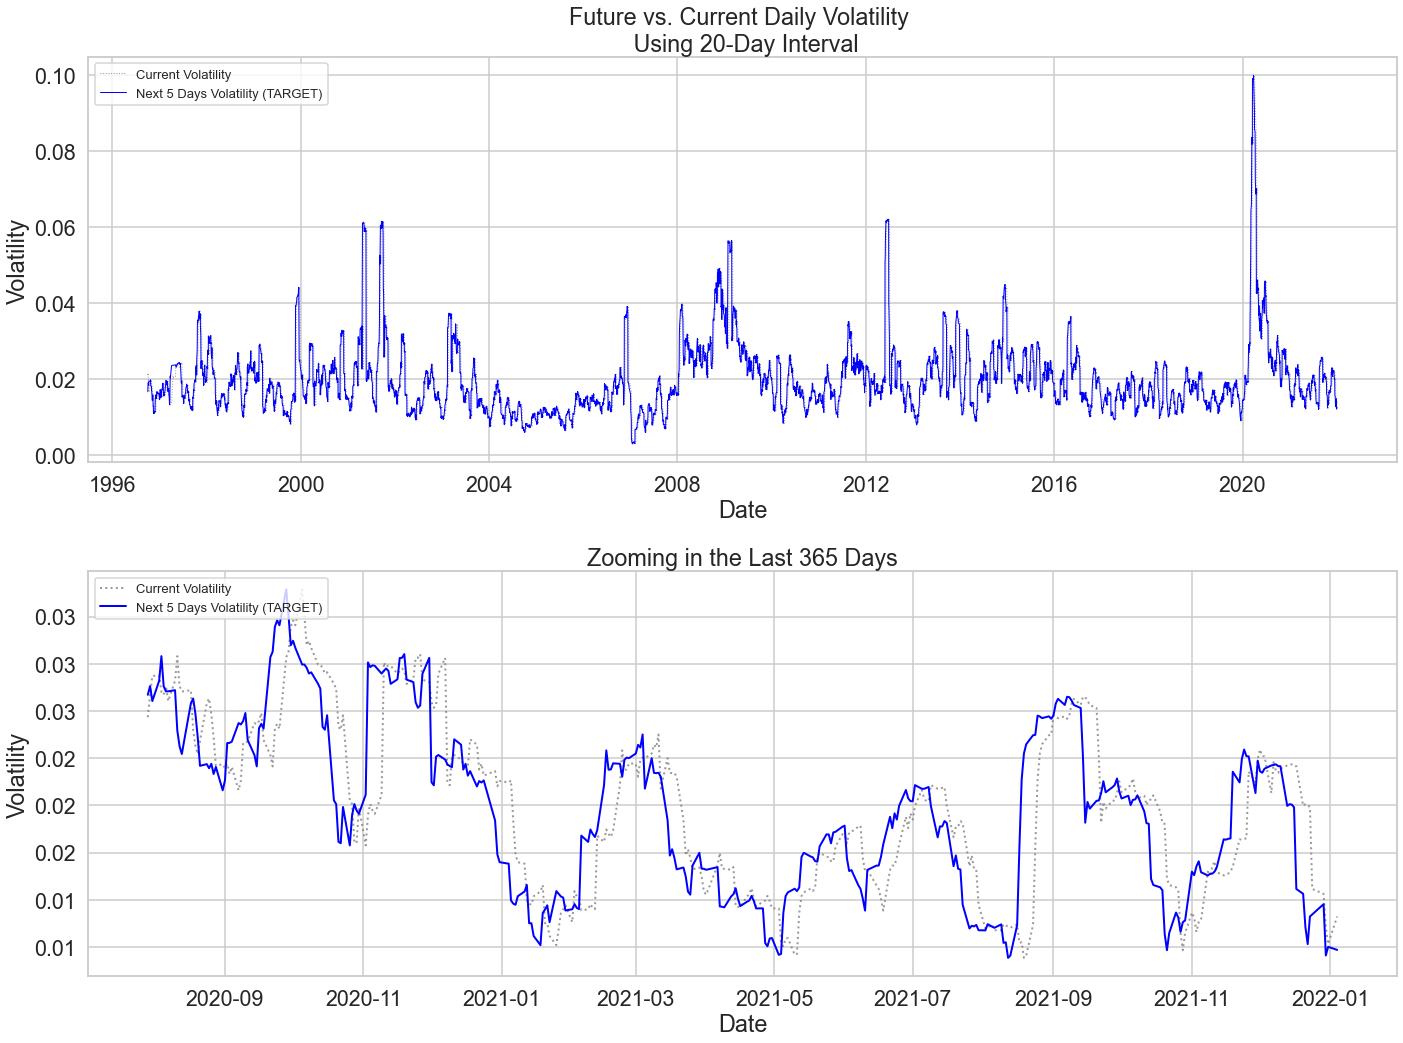

In [479]:
n_zoom = 365
sns.set_context("talk", font_scale=1.3)
# plt.style.use(['seaborn'])

# VISUALISE REALISED CURRENT VS. FUTURE VOLATILITY
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) #ensures y ticks displayed are to 2 decimal places

    ax1.plot(qantas.vol_current, alpha=.8, lw=1, color='gray', ls=':',
            label='Current Volatility')
    ax1.plot(qantas.vol_future, lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')
    
    ax1.set_ylabel('Volatility')
    ax1.set_xlabel('Date')
    
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) #ensures y ticks displayed are to 2 decimal places

    ax2.plot(qantas.vol_current[-n_zoom:], alpha=.8, lw=2, color='gray', ls=':',
            label='Current Volatility')
    ax2.plot(qantas.vol_future[-n_zoom:], lw=2, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax1.title.set_text(f'Future vs. Current Daily Volatility \n Using {INTERVAL_WINDOW}-Day Interval')
    ax2.title.set_text(f'Zooming in the Last {n_zoom} Days')
    
    ax2.set_ylabel('Volatility')
    ax2.set_xlabel('Date')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.tight_layout()
    plt.show();

# Daily volatility grouped by month

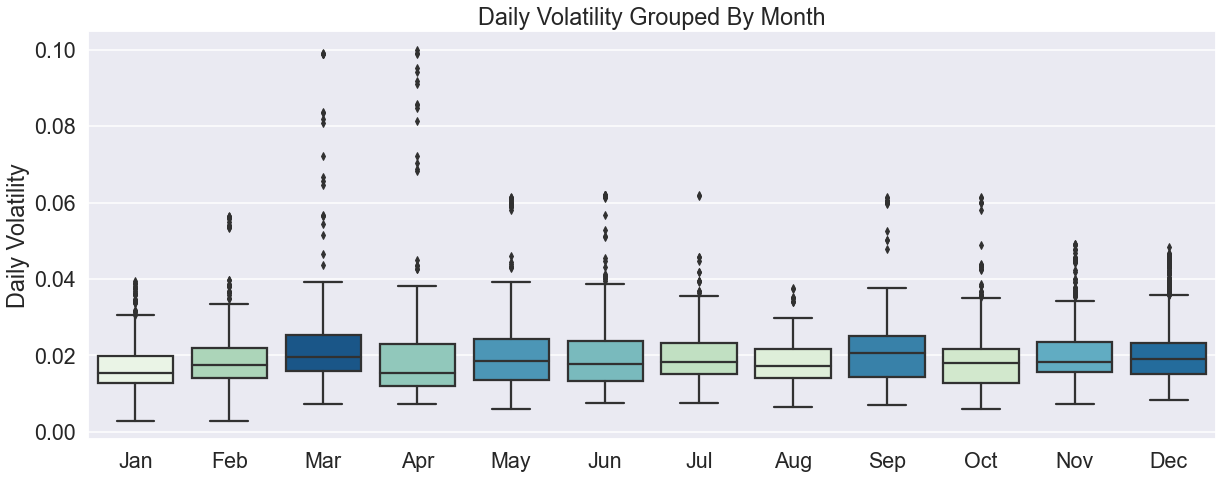

In [480]:
# PRESORT MONTHS IN CHRONOLOGICAL ORDER 
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun', 
                  'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']

# GROUP vol_current BY MONTH AND TAKE THE MEAN
data = qantas.groupby(by=[qantas.index.month_name()]).vol_current.mean()

# ABBREVIATE MONTH NAME
data.index = [x[:3] for x in data.index]

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort().reindex(ordered_months)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    
    sns.boxplot(x=[x[:3] for x in qantas.index.month_name()], 
                y=qantas.vol_current, 
                palette=np.array(pal)[rank],
                order=ordered_months)
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Month')
    plt.show()

It can be observed that:

Volatility has consistently reached some of its higher points in the in the months of May/June historically, with Jan/Aug some of its lower points

Feb/Mar/Apr have the most amount of large outliers


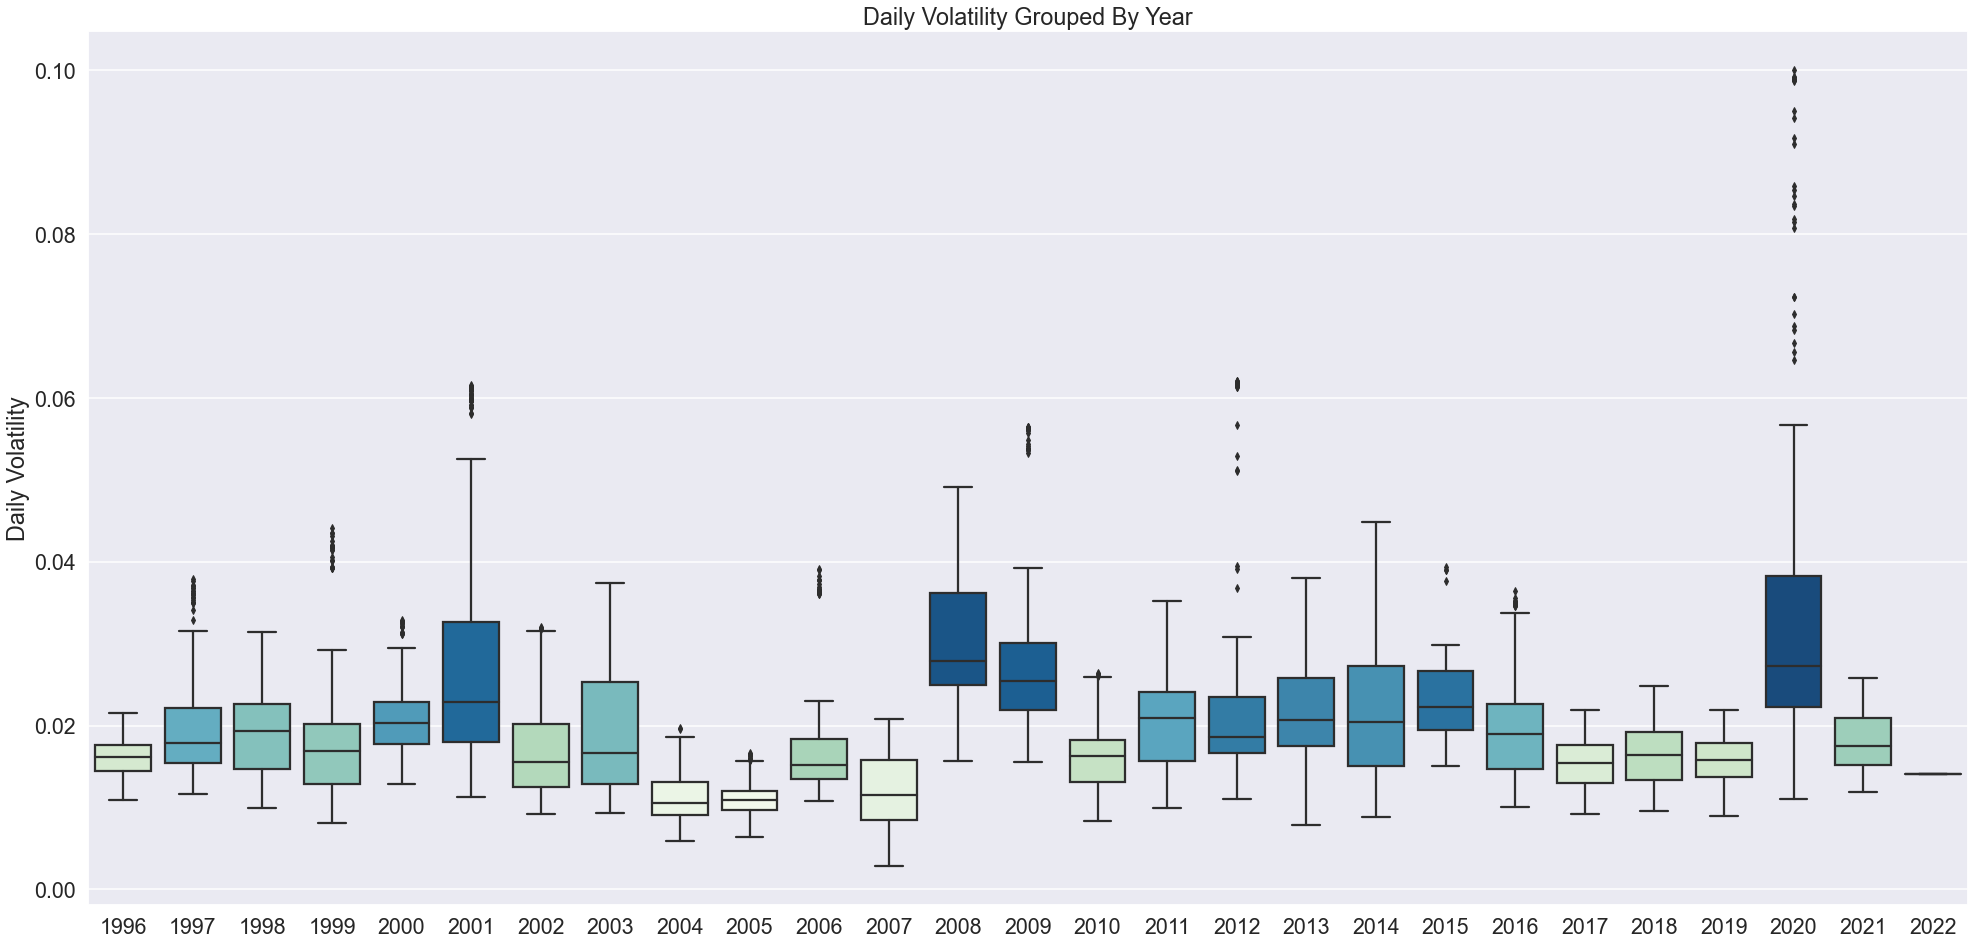

In [481]:
# GROUP vol_current BY YEAR AND TAKE THE MEAN
data = qantas.groupby(by=[qantas.index.year]).vol_current.mean()

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort()

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(30,15))
    
    sns.boxplot(x=qantas.index.year, 
                y=qantas.vol_current, 
                palette=np.array(pal)[rank])
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Year')
    plt.show()

Significant outliers can be observed during the 2009 GFC, and the 2020 COVID-19 halt on domestic/international travel. Additional events causing outliers include the 1997 Asian financial crisis and 2001 Dotcom-bubble.



# Daily volatility distribution


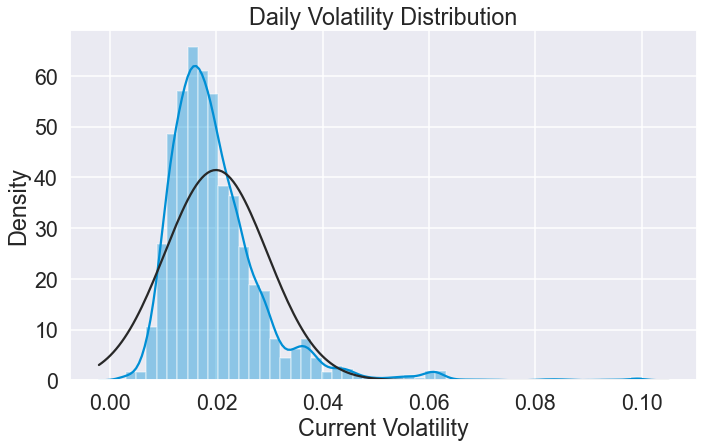

In [482]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(qantas.vol_current, norm_hist=True, fit=stats.norm,
                bins=50, ax=ax)
    plt.title('Daily Volatility Distribution')
    plt.xlabel('Current Volatility')
    plt.show();

The distribution of daily realized volatility is right skewed, with a number of larger values spreaded thinly on the right.

A skewed right distribution would have smaller median compared to mean, and mode smaller than median (mode < median < mean).

# Returns/Log Returns Stationarity Checking


In [483]:
from statsmodels.tsa.stattools import adfuller

# LOG RETURNS
adfuller_results = adfuller(qantas.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -31.38884993772696
p-value: 0.0
Critical Values:
1%: -3.4314
5%: -2.8620
10%: -2.5670


In [484]:
# RETURNS
adfuller_results = adfuller(qantas.returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -31.623434712738316
p-value: 0.0
Critical Values:
1%: -3.4314
5%: -2.8620
10%: -2.5670


Using a significant level alpha of 0.05, p-value for both Returns and Log Returns are significantly smaller than alpha, which means there's enough evidence to reject the Null Hypothesis.

--> Returns and Log returns are both not dependent on time/trend

# Train-Validation-Test Splits

In [485]:
len(qantas)

6334

We have 6713 observations of daily data. 

I will split the dataset into 3 components as follows:

1. The most recent 20 datapoints will be used for Final Model Testing - 0.29% 
2. Full year (252 days) for Validation and Model Tuning during training - 3.75%
3. Remaining for Training - 95.96%




In [486]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 20
val_size = 252

# CONVERT TO INDICES
split_time_1 = len(qantas) - (val_size + test_size)
split_time_2 = len(qantas) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = qantas.index[:split_time_1]
val_idx = qantas.index[split_time_1:split_time_2]
test_idx = qantas.index[split_time_2:]

In [487]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 1996-10-02 00:00:00 	to: 2020-12-04 00:00:00 	6062 days
VALIDATION 	From: 2020-12-07 00:00:00 	to: 2021-12-02 00:00:00 	252 days
TEST 		From: 2021-12-03 00:00:00 	to: 2022-01-04 00:00:00 	20 days


The target here would be **`vol_future`** which represents the daily realized volatility of the next **`n_future`** days from today (average daily volatility from `t` + `n_future` - `INTERVAL_WINDOW` to time step `t` + `n_future`).

For example, using an `n_future` value of 5 and an `INTERVAL_WINDOW` of 50, the value that I want to predict at time step `t` would be the average daily realised volatility from time step `t-14` (1+5-20) to time step `t+5`.

In [488]:
# SPLIT FORWARD VOLATILITY, CURRENT DAILY REALISED VOLATILITY, RETURNS, AND LOG RETURNS INTO TRAIN, VAL, TEST

# volatility target - target var
y_train = qantas.vol_future[train_idx]
y_val = qantas.vol_future[val_idx]
y_test = qantas.vol_future[test_idx]

# current volatility will be input for baseline, random walk, and NN models
x_train = qantas.vol_current[train_idx]
x_val = qantas.vol_current[val_idx]
x_test = qantas.vol_current[test_idx]

# returns will be input for GARCH models
r_train = qantas.returns[train_idx]
r_val = qantas.returns[val_idx]
r_test = qantas.returns[test_idx]

# log returns for visualisation
lr_train = qantas.log_returns[train_idx]
lr_val = qantas.log_returns[val_idx]
lr_test = qantas.log_returns[test_idx]


# Data Preprocessing

# 1. Feature Normalisation

As we are going to use various types of models that are based on different algorithms using different types of inputs, it would be better to normalise the volatilities to standardise the predictions generated. MinMaxScaler will be used.


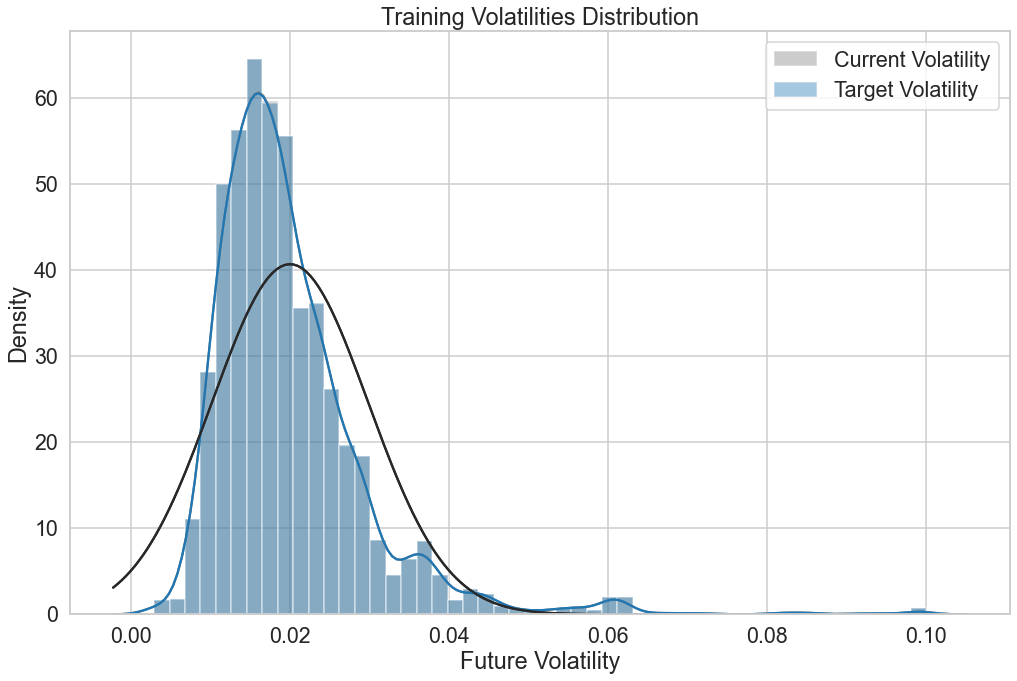

In [489]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(15,10))
    sns.distplot(x_train, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution')
    plt.xlabel('Future Volatility')
    plt.legend()
    plt.show();

In [490]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [491]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

# Ref: https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95
# ADJUST COLUMN WIDTH IN PANDAS TO SHOW ALL TEXT
# (FOR MODEL PERFORMANCE DISPLAY LATER)

pd.set_option('display.max_colwidth', None)

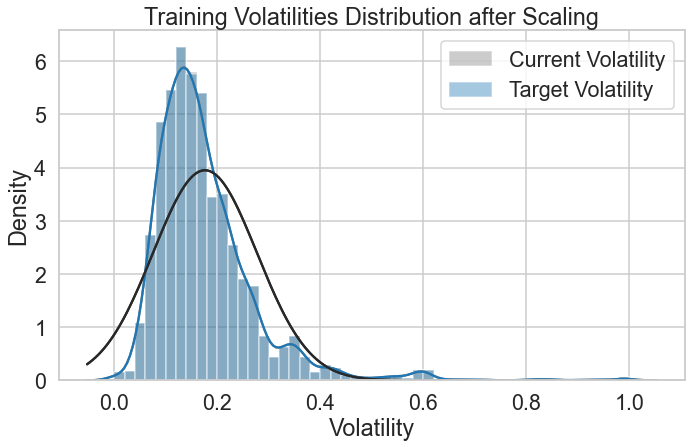

In [492]:
# PLOTTING VOLATILITIES AFTER SCALING
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()
    plt.xlabel('Volatility')
    plt.show();

# 2. Train-Validation-Test Visualization


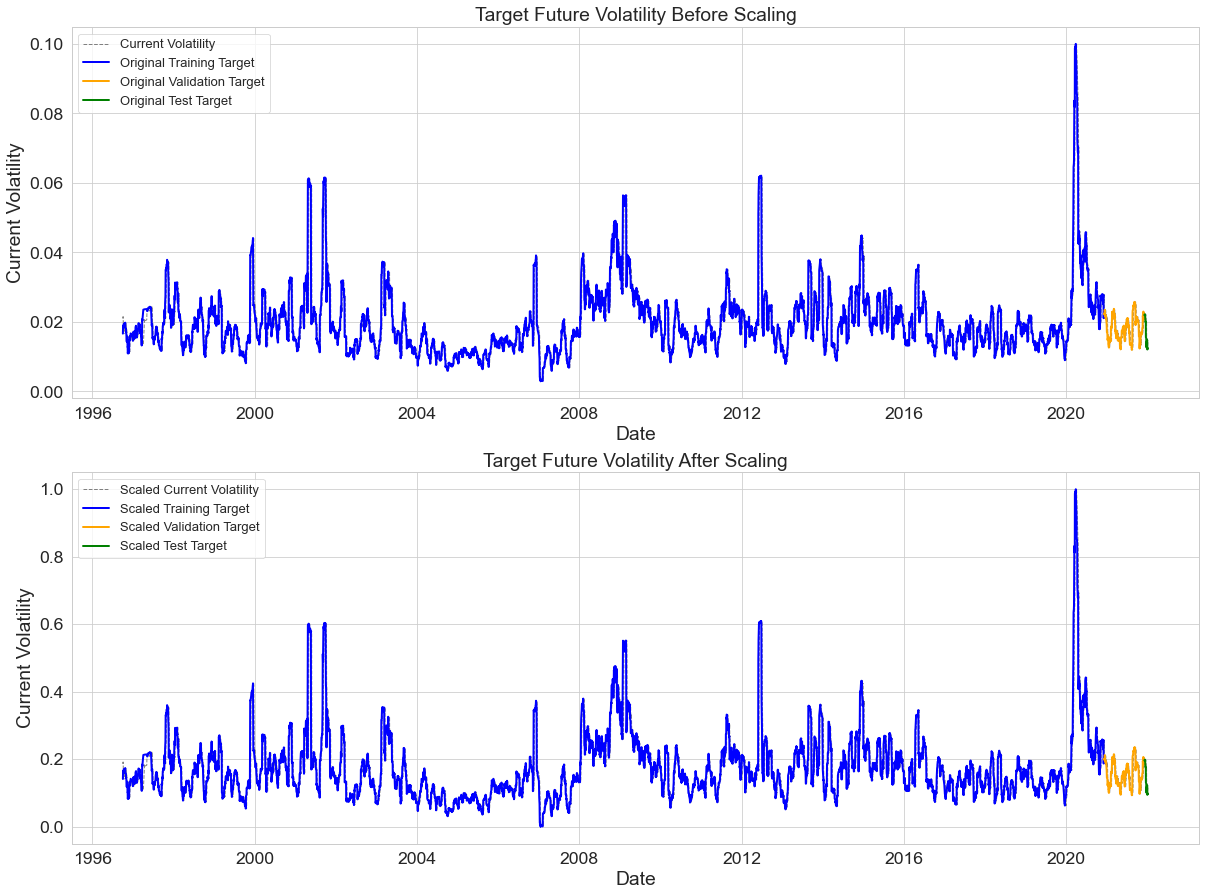

In [493]:
sns.set_context("paper", font_scale=2)

# VISUALISE TRAIN/VALIDATION/TEST vol_future BEFORE & AFTER TRAINING
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(qantas.vol_current, lw=1, color='gray', ls='--',
                label='Current Volatility')
    ax1.plot(y_train, color='blue', label='Original Training Target', lw=2)
    ax1.plot(y_val, color='orange', label='Original Validation Target', lw=2)
    ax1.plot(y_test, color='green', label='Original Test Target', lw=2)
    
    ax1.set_ylabel('Current Volatility')
    ax1.set_xlabel('Date')

    ax1.title.set_text('Target Future Volatility Before Scaling')

    ax2.plot(transform_volatility_to_scaler(scaler_vol, qantas.vol_current), 
                lw=1, color='gray', ls='--',
                label='Scaled Current Volatility')
    ax2.plot(y_train_scaled, color='blue', label='Scaled Training Target', lw=2)
    ax2.plot(y_val_scaled, color='orange', label='Scaled Validation Target', lw=2)
    ax2.plot(y_test_scaled, color='green', label='Scaled Test Target', lw=2)

    ax2.set_ylabel('Current Volatility')
    ax2.set_xlabel('Date')
    
    ax2.title.set_text('Target Future Volatility After Scaling')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.show();

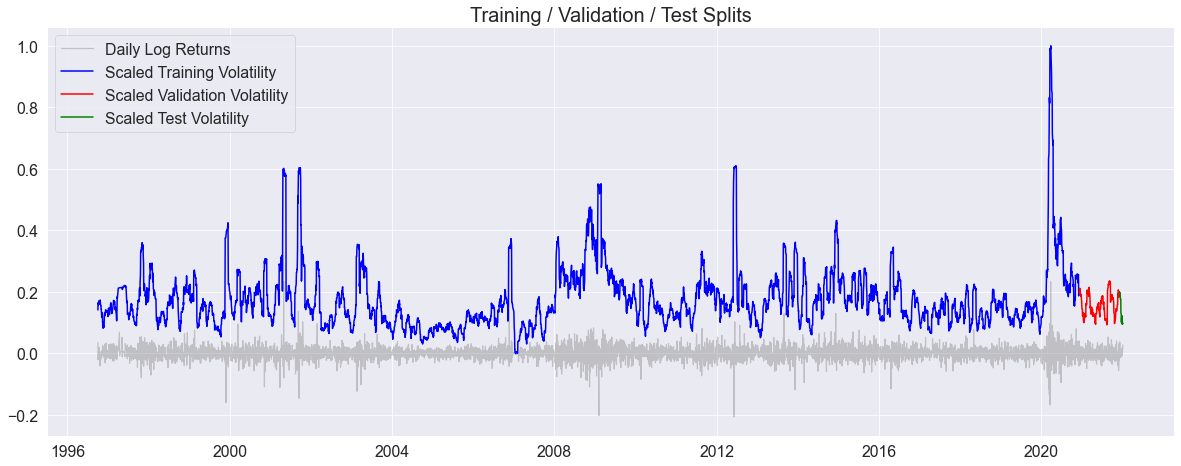

In [494]:
sns.set_context("paper", font_scale=1.8)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,7))

    plt.plot(qantas.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

    plt.plot(y_train_scaled, color='blue', 
             label='Scaled Training Volatility', lw=1.5)
    plt.plot(y_val_scaled, color='red', 
             label='Scaled Validation Volatility', lw=1.5)
    plt.plot(y_test_scaled, color='green', 
             label='Scaled Test Volatility', lw=1.5)

    plt.plot()
    plt.title('Training / Validation / Test Splits', fontsize=20)
    plt.legend(frameon=True)
    plt.show();

# Modelling

# 1. Performance Metrics

Usually with financial time series, if we just shift through the historic data trying different methods, parameters and timescales, it's almost certain to find to some strategy with in-sample profitability at some point. However the whole purpose of "forecasting" is to predict the future based on currently available information, and a model that performs best on training data might not be the best when it comes to out-of-sample generalisation (or overfitting). Avoiding/Minimising overfitting is important.


The two main metrics we will be using are RMSPE (Root Mean Squared Percentage Error) and RMSE (Root Mean Square Errors). Timescaling is very important in the calculation of volatility due to the level of freedom in frequency/interval window selection. Therefore I think RMSPE would help capture degree of errors compared to desired target values better than other metrics. Also RMSPE would punish large errors more than regular MAPE (Mean Absolute Percentage Error), which is what we want to do here.

RMSE and RMSPE would be tracked across different models' performance on validation set forecasting to indicate their abilities to generalise on out-of-sample data.

In [495]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [496]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [497]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])


In [498]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred)]
    return perf_df

In [499]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def visualise_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

# 2. Baseline models

The baseline models will include:
1. Mean baseline 
2. Random walk naive forecasting

**Mean baseline** 

One of the characteristics of volatility is mean reversion over the long-term. Therefore, the first baseline model will be one that outputs the average current realised volatility of the whole training set as predictions everything.

**Random walk naive forecasting**

Volatility tends to be autocorrelated, and clusters in the short-term. This property can be used to implement a naive model that just predicts future volatility by using the daily volatility at the previous time step.

# 2.1 Mean baseline

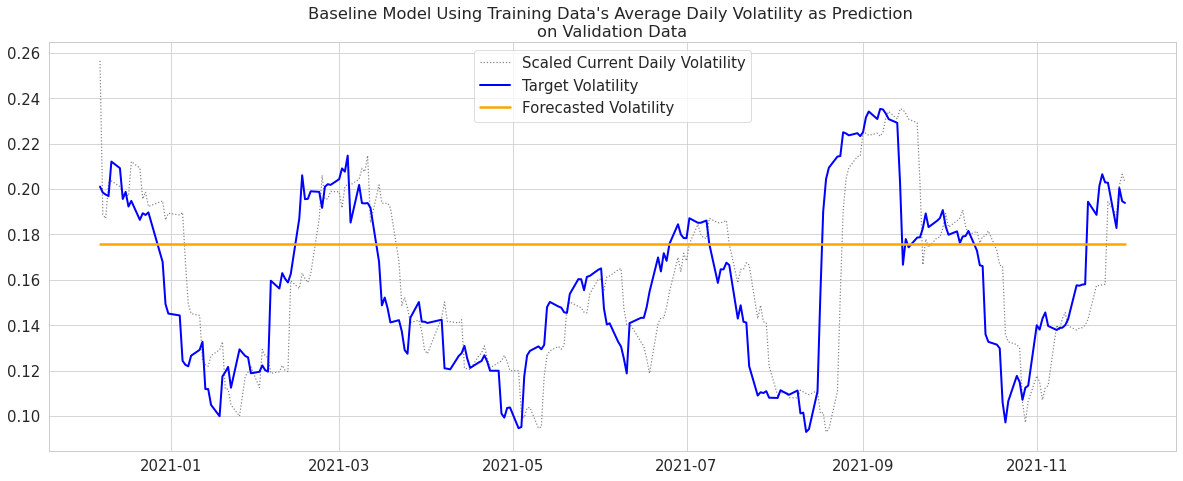

In [500]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_train_vol = x_train_scaled.mean()

# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

visualise_model(y_val_scaled, baseline_preds, 
          f"Baseline Model Using Training Data's Average Daily Volatility as Prediction")
plt.show();

In [501]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')


Model  Validation RMSPE  Validation RMSE
0  Mean Baseline          0.331782         0.040707

# 2.2 Random Walk Naive Forecasting 

I'll use the average daily volatility of the most recent `INTERVAL_WINDOW` as predictions for the next 7 days, which is essentially using `vol_current` at time step `t` and prediction for `vol_future` at time step `t`.

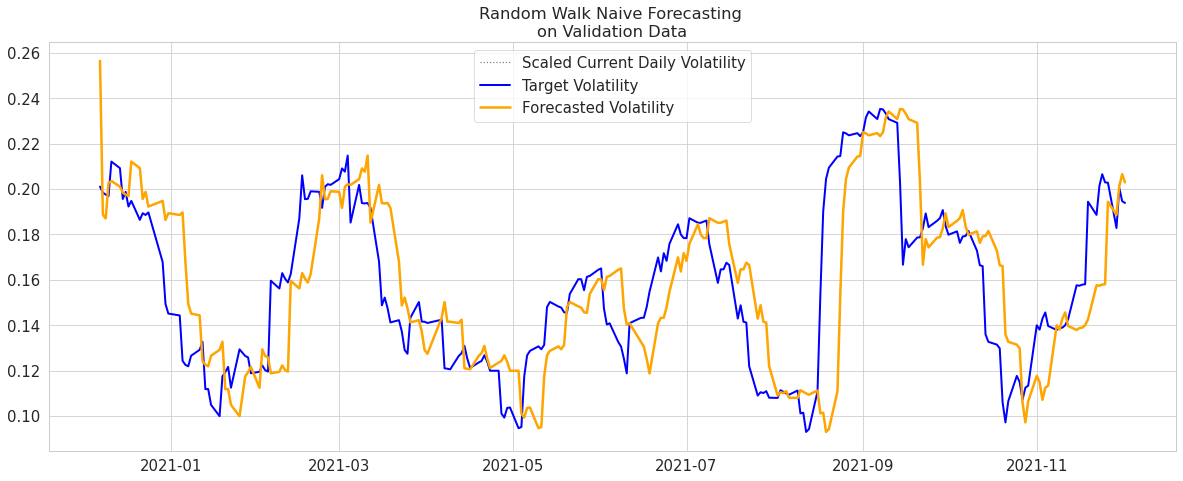

In [502]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
visualise_model(y_val_scaled, random_walk_preds, 'Random Walk Naive Forecasting')
plt.show();

In [503]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, random_walk_preds, 
         'Random Walk Naive Forecasting')

Model  Validation RMSPE  Validation RMSE
0                  Mean Baseline          0.331782         0.040707
1  Random Walk Naive Forecasting          0.173708         0.026888

Both error metrics have fallen using naive forecasting. This simple method can be at times difficult to outperform. 

# 3. GARCH models 

GARCH stands for Generalized Autoregressive Conditional Heteroskedasticity, which is an extension of the ARCH model (Autoregressive Conditional Heteroskedasticity).

GARCH includes **lag variance terms with lag residual errors from a mean process, and is the traditional econometric approach to volatility prediction of financial time series.**

GARCH models capture the characteristics of volatility: volatility tomorrow will be close to what it is today (clustering), and volatility in the long-term will probably mean revert to the historical long-term average.

GARCH can be represented as follows:

$$\sigma^{2}_{t} = w + \sum \limits _{i} ^{q} \alpha_{i}\epsilon^{2}_{t-1} + \sum \limits _{1} ^ {p} \beta_{i}\sigma^{2}_{t-1}$$

where, $w$ is the long-term variance, $\sigma^{2}_{t}$ is variance at time t and $\epsilon^{2}_{t-1}$ is the model residuals at time t-1

GARCH(1,1) only contains first-order lagged terms and the equation for it is:

$$\sigma^{2}_{t} = w +\alpha \epsilon^{2}_{(t-1)} +  \beta \sigma^{2}_{(t-1)}$$

where , $\alpha$, $\beta$, and $w$ sum up to 1

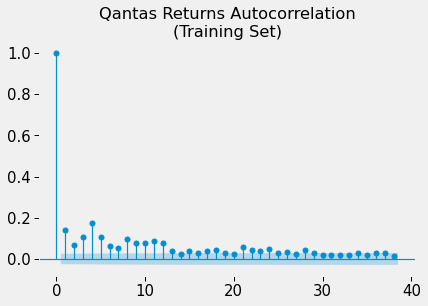

In [504]:
# VISUALISE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2, title= 'Qantas Returns Autocorrelation\n(Training Set)');

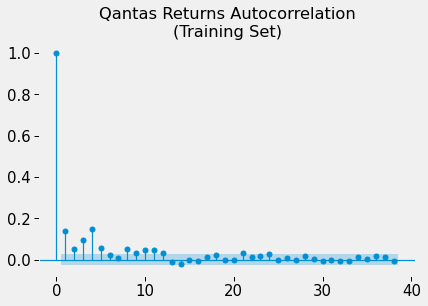

In [505]:
# VISUALISE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2, title= 'Qantas Returns Autocorrelation\n(Training Set)');

The autocorrelation plot seems to indicate correlation up to the 40th lag (Odd??). Using the partial autocorrelation plot, there seems to be significant correlation up to the 7th lag. 

Lets try 7th lag:

In [506]:
# SET SEED FOR REPRODUCIBILITY
seed = 42

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gm_1 = arch_model(r_train, p=7, q=7)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12699.4
Distribution:                  Normal   AIC:                           25430.9
Method:            Maximum Likelihood   BIC:                           25538.2
                                        No. Observations:                 6062
Date:                Thu, Jan 13 2022   Df Residuals:                     6061
Time:                        00:10:34   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0668  2.616e-02      2.553  1.067e-02 [1.552e-

Using a significance level of 0.05, the coefficients do not seem to be statistically significant (because their p-values P > |t| are all greater than 0.05). Therefore, I'll reduce the values of p and q to 1 to see if that helps.

In [507]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12715.0
Distribution:                  Normal   AIC:                           25437.9
Method:            Maximum Likelihood   BIC:                           25464.8
                                        No. Observations:                 6062
Date:                Thu, Jan 13 2022   Df Residuals:                     6061
Time:                        00:10:35   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0678  2.384e-02      2.846  4.429e-03 [2.112e-

After being fitted to the training data (percent returns), the GARCH model forecast contains an estimated conditional volatility attribute for the training portion of the time series. I am going to fit - transform the scaler to the training data's conditional volatility arrays, and then plot it out to compare it with the realised volatility calculated above (also scaled) `x_train_scaled`.

In [508]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility 
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [509]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [510]:
# VISUALISE MODEL'S ESTIMATED CONDITIONAL VOLATILITY 
# WITH SCALED vol_current CALCULATED ABOVE
def visualise_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realised Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

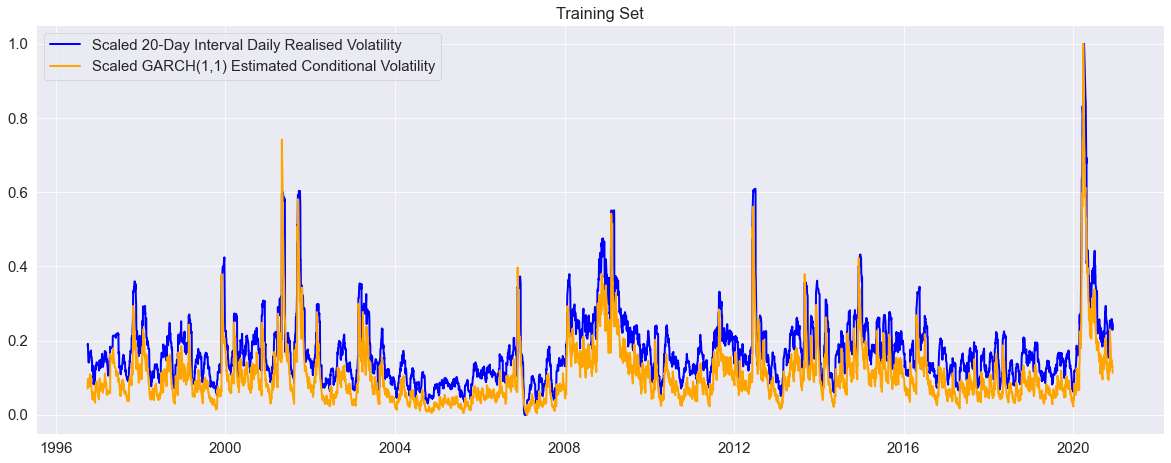

In [511]:
visualise_cond_vol(scaled_cond_vol, 'GARCH(1,1)')

3.1.1. Analytical-based Forecasting

(Source: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html)

I am implementing rolling one-step forecasting here by refitting the model to ALL the datapoints available up to a certain time step before generating prediction for the next n_future days. For example, to make prediction on vol_future at time step t, I would fit the model to all the returns available up to time step t and then obtain the average forecasted volatility for a horizon of `n_future` = 5.

The volatility forecasts from the GARCH models using percent returns as input are on a totally different scale compared to the volatilities calculated from log returns. Therefore I am going to normalise the forecasted volatility based on the model's conditional_volatility output from the training data, and only comparing the scaled versions of volatilities on the Validation set.

In [512]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALISING rolling_forecast
rolling_forecasts = []
idx = qantas.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = qantas.returns[:idx]
    
    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

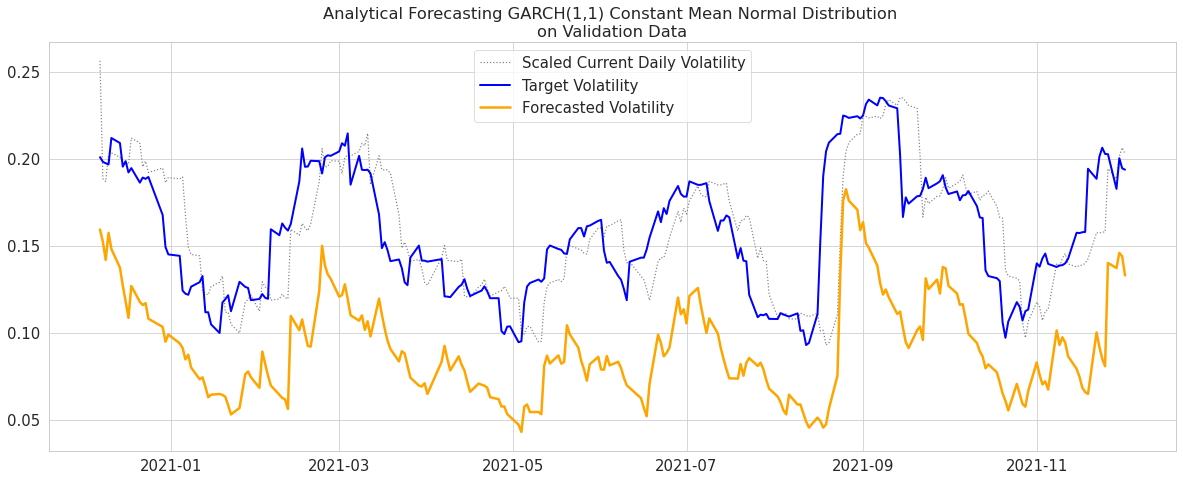

In [513]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
visualise_model(y_val_scaled, gm_1_preds_scaled, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

So 5-day horizon forecasting into the future is still lagging behind compared to target values. Similar to the training volatilities comparison above, GARCH's forecasted volatility appears to be lower side (after normalisation).

In [514]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled, 
         'GARCH(1,1), Constant Mean, Normal Dist')

Model  Validation RMSPE  Validation RMSE
0                           Mean Baseline          0.331782         0.040707
1           Random Walk Naive Forecasting          0.173708         0.026888
2  GARCH(1,1), Constant Mean, Normal Dist          0.434597         0.069829

Next, I would inspect the estimated residuals from this first GARCH model.



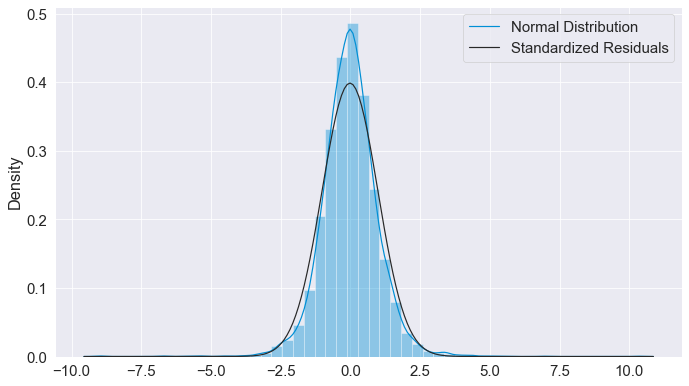

In [515]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDISING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALISING STANDARDISED RESIDUALS VS. A NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show();

By default, basic GARCH is based on some assumptions that the residuals and the mean return are both normally distributed. However, more often than not, financial time series data does not follow a normal distribution, and it's more likely to observe extreme positive and negative values that are far away from the mean.

Fortunately, there're certain parameters that can be specified in the arch_model library to make it more representative of real financial data:

`dist` can be set to t for Student's T or `skewt` for skewed Student's T distribution (Student's T distribution is also symmetric and bell-shaped like normal distribution; however it has higher peak and fatter tails allowing more values lying further away from the mean).
Looking at the plot above of the standardised residuals, I think I can try skewed Student's T for the next fit.

# 3.2. GARCH Model with Asymmetric Shocks Responses


3.2. GARCH Model with Asymmetric Shocks Responses

The basic GARCH model assumes positive and negative news have similar impact on volatility. However, in reality the market tends to "take the stairs up and the elevator down". In other words, the impact is usually asymmetric, and negative impacts tends to affect the volatility more than positive ones.

There's another member in the GARCH family that accounts for assymmetry of shocks reponses called GJR-GARCH (short for Glosten-Jagannathan-Runkle GARCH).

Additional inputs can be used to construct other models. In this case, by setting `o` to 1, which means the model would include one lag of an asymmetric shock which transforms a GARCH model into a GJR-GARCH model with variance dynamics.

In [516]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gjr_gm = arch_model(r_train, p=1, q=1, o=1, 
                    vol='GARCH', dist='skewt')
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -12357.0
Distribution:      Standardized Skew Student's t   AIC:                           24727.9
Method:                       Maximum Likelihood   BIC:                           24774.9
                                                   No. Observations:                 6062
Date:                           Thu, Jan 13 2022   Df Residuals:                     6061
Time:                                   00:10:50   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

Log-likelihood has increased quite a bit compared to GARCH. Let's see how the conditional volatility looks.

In [517]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_2)

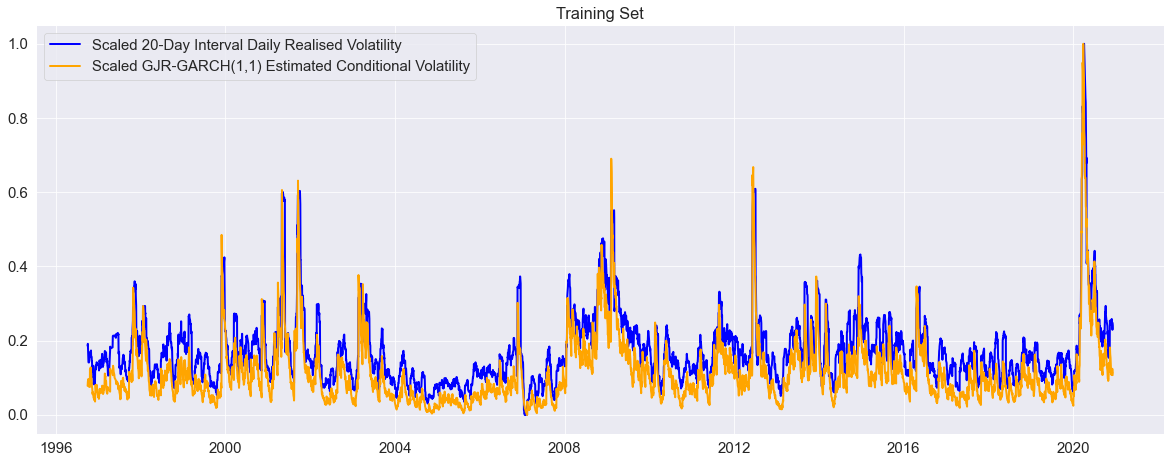

In [518]:
visualise_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [519]:
# ROLLING WINDOW FORECAST
# INITIALISING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = qantas.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

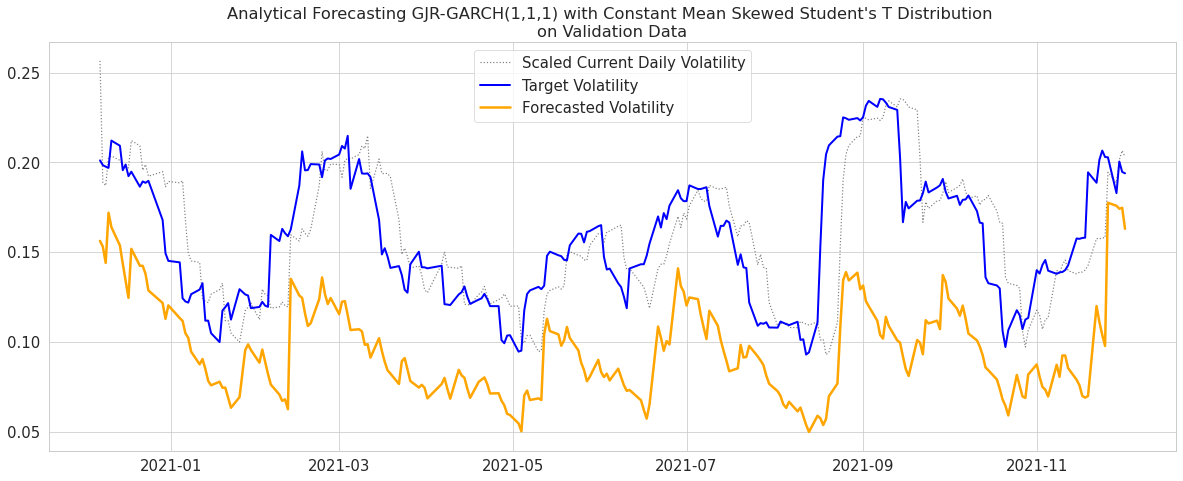

In [520]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
visualise_model(y_val_scaled, gjr_1_preds_scaled, 
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")


In [521]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_1_preds_scaled, 
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.331782   
1                           Random Walk Naive Forecasting          0.173708   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.434597   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.403040   

   Validation RMSE  
0         0.040707  
1         0.026888  
2         0.069829  
3         0.066940

Slighty better than GJR-GARCH with normal dist

# 3.3. TARCH

(Reference: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html#Specifying-Common-Models)

There's another member in the GARCH family called TARCH, which is short for Threshold Autoregressive Conditional Heteroskedasticity). TARCH models the volatility using absolute values (instead of squares). This model is specified using power=1.0 since the default power, 2.0, corresponds to variance processes that evolve in squares. In addition, asymmetric impact is also incorporated into the GARCH framework by using a dummy variable

The volatility process in a TARCH(1,1) model is given by:


$$\sigma_{t} = w +\alpha |\epsilon_{t-1}| +  \gamma |\epsilon_{t-1}|I_{[\epsilon_{t-1}<0]}+ \beta \sigma_{t-1}$$


In [522]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm = arch_model(r_train, p=1, o=1, q=1, power=1, dist='skewt') #skewt dist TARCH
result_3 = t_gm.fit(disp='off')
print(result_3.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -12334.4
Distribution:      Standardized Skew Student's t   AIC:                           24682.7
Method:                       Maximum Likelihood   BIC:                           24729.7
                                                   No. Observations:                 6062
Date:                           Thu, Jan 13 2022   Df Residuals:                     6061
Time:                                   00:11:19   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

Adjust `q` to 2 in TARCH

In [523]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm = arch_model(r_train, p=1, o=1, q=2, power=1, dist='skewt') #skewt dist TARCH
result_3 = t_gm.fit(disp='off')
print(result_3.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -12331.2
Distribution:      Standardized Skew Student's t   AIC:                           24678.4
Method:                       Maximum Likelihood   BIC:                           24732.1
                                                   No. Observations:                 6062
Date:                           Thu, Jan 13 2022   Df Residuals:                     6061
Time:                                   00:11:19   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

Log-likelihood and AIC/BIC are higher than the GJR-GARCH and GARCH model. We will inspect the estimated conditional volatility compared to the scaled vol_current.

In [524]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch, scaled_tarch_cond_vol = scale_tf_cond_vol(result_3)

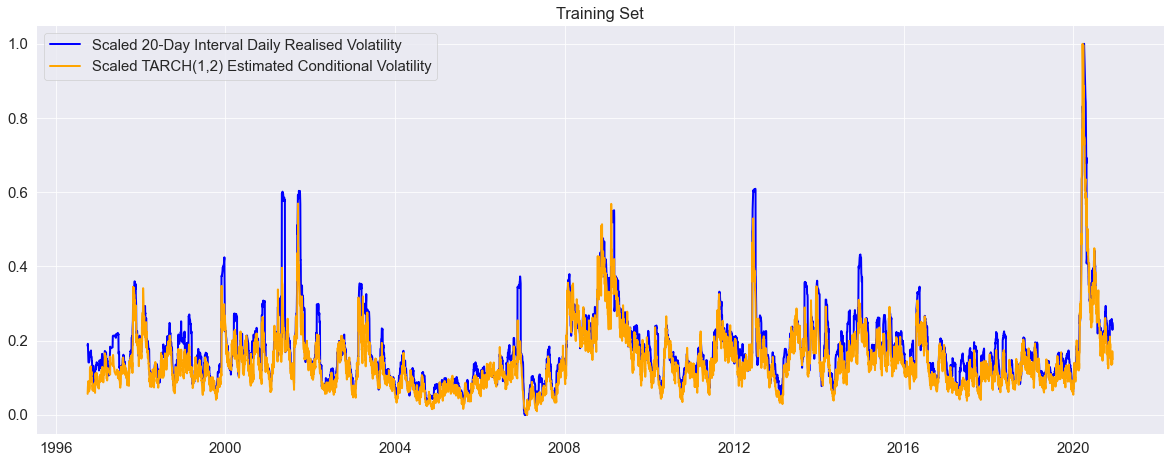

In [525]:
visualise_cond_vol(scaled_tarch_cond_vol, 'TARCH(1,2)') #TARCH(1,1) tested above too


# 3.3.1. Bootstrap-based Forecasting for TARCH(1,1)

(Reference: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html#TARCH)

TARCH models do not have closed-form (analytical) forecasts for horizons larger than 1, and so simulation or bootstrapping is required. Attempting to produce forecasts for horizons larger than 1 using method='analytical' results in a ValueError.

Bootstrap-based forecasts are nearly identical to simulation-based forecasts except that the values used to simulate the process are computed from historical data rather than using the assumed distribution of the residuals. Forecasts produced using this method also return an ARCHModelForecastSimulation containing information about the simulated paths.

In [526]:
# ROLLING WINDOW FORECAST
# INITIALISING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = qantas.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [527]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_bs_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_bs_preds)

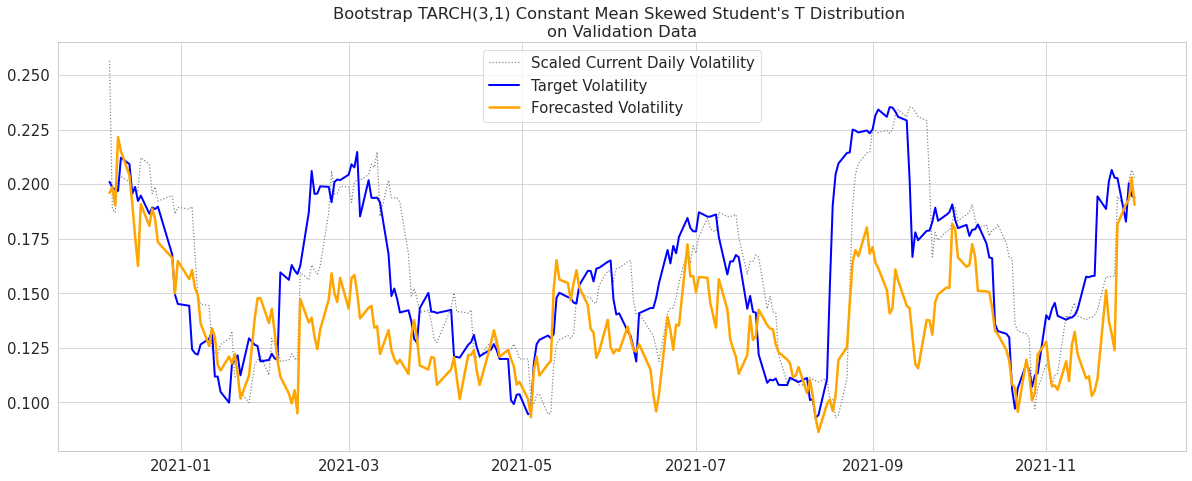

In [528]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
visualise_model(y_val_scaled, t_bs_preds_scaled, 
          "Bootstrap TARCH(3,1) Constant Mean Skewed Student's T Distribution")

In [529]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_bs_preds_scaled, 
         "Bootstrap TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.331782   
1                           Random Walk Naive Forecasting          0.173708   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.434597   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.403040   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.198465   

   Validation RMSE  
0         0.040707  
1         0.026888  
2         0.069829  
3         0.066940  
4         0.036207

Bootstrap TARCH(1,1) outperforms the other GARCH variants, but still not random walk naive forecasting.

# 3.3.2. Simulation-based Forecasting for TARCH(1,1)


In [530]:
# ROLLING WINDOW FORECAST
# INITIALISING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = qantas.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING SIMULATION METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='simulation').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_sm_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

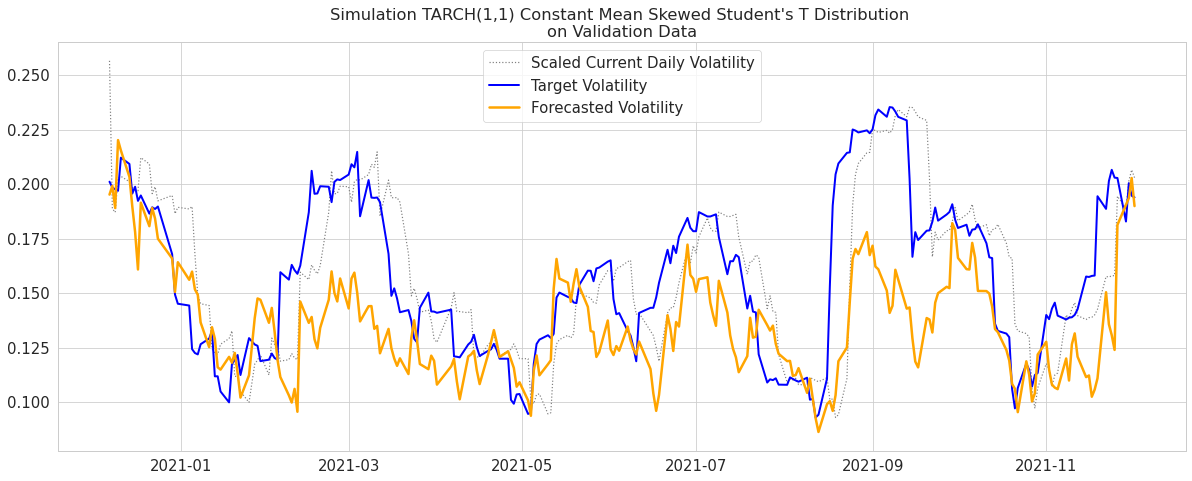

In [531]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_sm_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_sm_preds)

# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
visualise_model(y_val_scaled, t_sm_preds_scaled, 
          "Simulation TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [532]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_sm_preds_scaled, 
         "Simulation TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.331782   
1                           Random Walk Naive Forecasting          0.173708   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.434597   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.403040   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.198465   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.198495   

   Validation RMSE  
0         0.040707  
1         0.026888  
2         0.069829  
3         0.066940  
4         0.036207  
5         0.036242

Among the 2 forecasting methods, bootstrap uses historical data in to compute rather than using the assumed distribution of the residuals in simulation. 

# 3.3.3. Hyperparameter Tuning for TARCH

Next, I'll create a range of values for p, q and o from 0 to 3 (inclusive), and then record each's model's performance on unseen data using RMSPE. Since p cannot take a value of 0, I'll eliminate that from the list of permutations.

In [533]:
import itertools

In [534]:
pqo_s = [p for p in itertools.product(range(3), repeat=3)]
# ELIMINATE PERMUTATIONS WITH p = 0
pqo_s = list(filter(lambda x: x[0] != 0, pqo_s))
# RMSPE ON VALIDATION SET
rmspe_s = []
# LOG LIKELIHOOD
LLH_s = []
# BIC
bic_s = []

for p, q, o in pqo_s:
    # SET SEED FOR REPRODUCIBILITY
    np.random.seed(seed)

    # FITTING TARCH(p,q,o) MODEL
    t_gm_pqo = arch_model(r_train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
    t_gm_pqo_fit = t_gm_pqo.fit(disp='off')

    # SCALING CONDITIONAL VOLATILITY OUTPUTS
    sclr = MinMaxScaler()
    cond_vol_arr = t_gm_pqo_fit.conditional_volatility.values.reshape(-1,1)

    # FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
    sclr = sclr.fit(cond_vol_arr)

    # INITIALISING rolling_forecasts VALUES LIST
    rolling_forecasts = []

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(r_val)):
        # GET THE DATA AT ALL PREVIOUS TIME STEPS
        idx = val_idx[i]
        train = qantas.returns[:idx].dropna()

        # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
        model = arch_model(train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
        model_fit = model.fit(disp='off')

        # MAKE PREDICTION
        vaR = model_fit.forecast(horizon=n_future, 
                                 reindex=False,
                                 method='bootstrap').variance.values
        pred = np.sqrt(np.mean(vaR))

        # APPEND TO rolling_forecasts LIST
        rolling_forecasts.append(pred)

    # CONVERT PREDICTIONS
    y_preds = pd.Series(rolling_forecasts, index=val_idx)

    # TRANSFORM PREDICTIONS USING FITTED SCALER FOR SPECIFIC p/q/o SET
    y_preds_scaled = transform_volatility_to_scaler(sclr, y_preds)
    
    # APPENDING PERFORMANCE METRICS TO LISTS
    LLH_s.append(t_gm_pqo_fit.loglikelihood)
    bic_s.append(t_gm_pqo_fit.bic)
    rmspe_s.append(RMSPE(y_val_scaled, y_preds_scaled))

In [535]:
# GET THE VALUES OF p/q/o THAT YIELDS LOWEST VALIDATION RMSPE
print(f'Lowest RMSPE is {np.min(rmspe_s)} using TARCH{pqo_s[np.argmin(rmspe_s)]}')

Lowest RMSPE is 0.18544304106075596 using TARCH(1, 1, 0)


In [536]:
best_pqo = pqo_s[np.argmin(rmspe_s)]

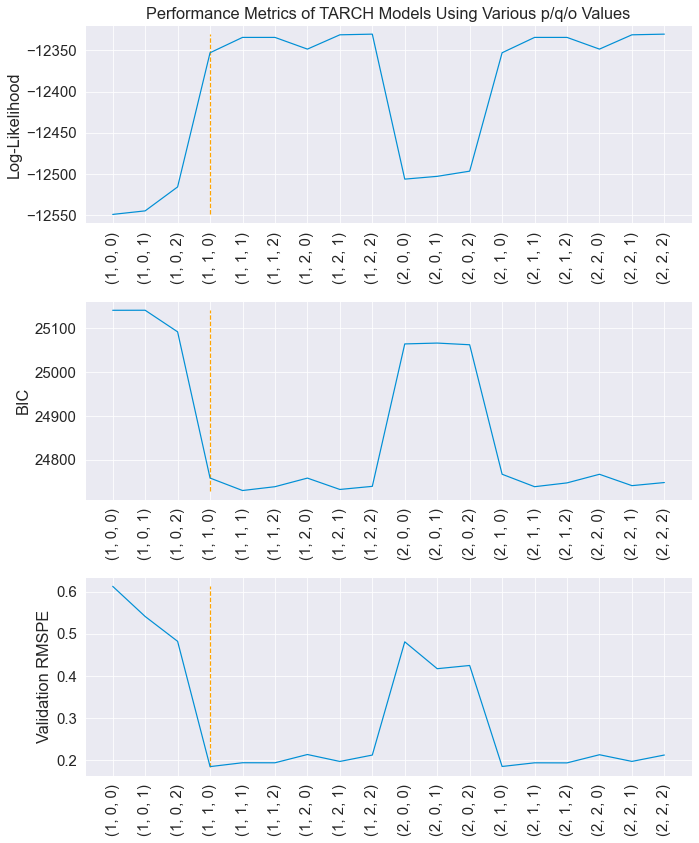

In [537]:
with sns.axes_style("darkgrid"):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
    xlabels = [str(v) for v in pqo_s]

    ax1.plot(xlabels, LLH_s)
    ax1.set_xticklabels(xlabels, rotation=90)
    ax1.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(LLH_s), ymax=np.max(LLH_s))
    ax1.set_ylabel('Log-Likelihood')

    ax2.plot(xlabels, bic_s)
    ax2.set_xticklabels(xlabels, rotation=90)
    ax2.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(bic_s), ymax=np.max(bic_s))
    ax2.set_ylabel('BIC')

    ax3.plot(xlabels, rmspe_s)
    ax3.set_xticklabels(xlabels, rotation=90)
    ax3.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(rmspe_s), ymax=np.max(rmspe_s))
    ax3.set_ylabel('Validation RMSPE')

    ax1.set_title('Performance Metrics of TARCH Models Using Various p/q/o Values')
    plt.tight_layout()
    plt.show();    

So it seems (1,1,0) yields lowest RMPSE on validation set among all the variants I've tried. I'm going to create another TARCH model with this paramaters to see how the results would look like.

In [538]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_120 = arch_model(r_train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                  dist='skewt')
result_4 = t_120.fit(disp='off')
print(result_4.summary())

                          Constant Mean - AVGARCH Model Results                          
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                               AVGARCH   Log-Likelihood:               -12353.0
Distribution:      Standardized Skew Student's t   AIC:                           24717.9
Method:                       Maximum Likelihood   BIC:                           24758.2
                                                   No. Observations:                 6062
Date:                           Thu, Jan 13 2022   Df Residuals:                     6061
Time:                                   00:23:18   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

In [539]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch_120, scaled_tarch_120_cond_vol = scale_tf_cond_vol(result_4)

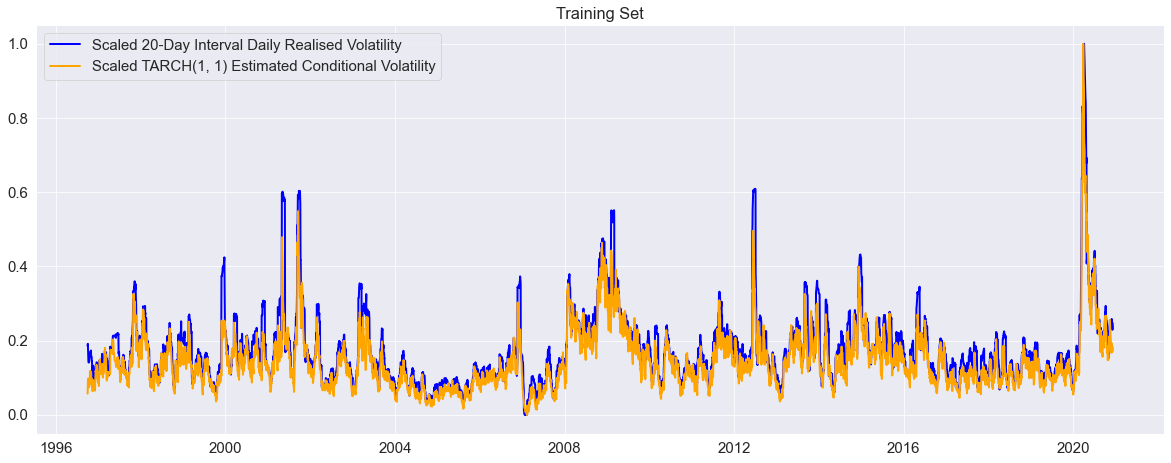

In [540]:
visualise_cond_vol(scaled_tarch_120_cond_vol, f'TARCH{best_pqo[:2]}')


In [541]:
# ROLLING WINDOW FORECAST
# INITIALISING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = qantas.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_120_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [542]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_120_preds_scaled = transform_volatility_to_scaler(scaler_tarch_120, t_bs_120_preds)

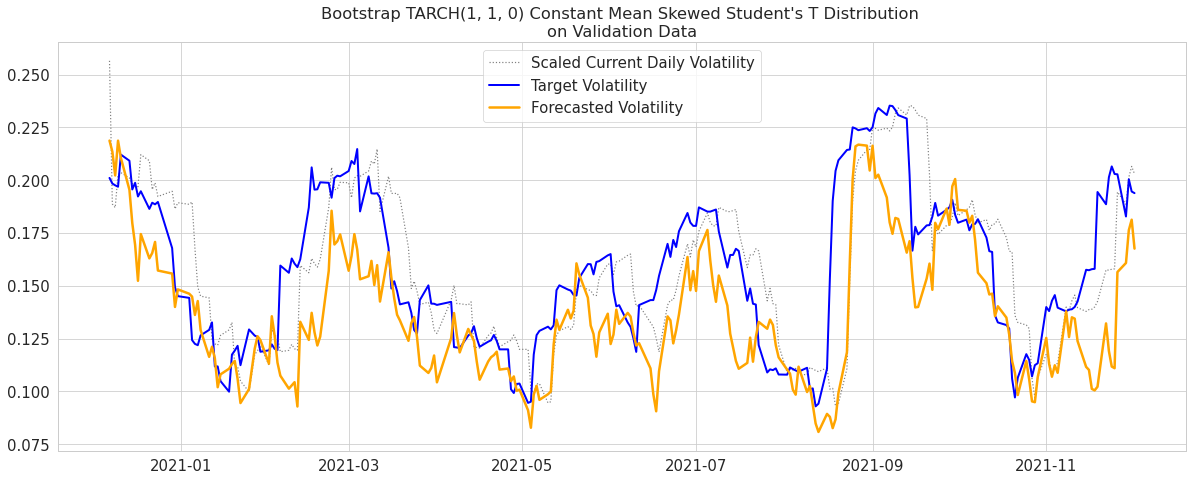

In [543]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
visualise_model(y_val_scaled, t_120_preds_scaled, 
          f"Bootstrap TARCH{best_pqo} Constant Mean Skewed Student's T Distribution")
plt.show();

In [544]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_120_preds_scaled, 
         f"Bootstrap TARCH{best_pqo}, Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.331782   
1                           Random Walk Naive Forecasting          0.173708   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.434597   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.403040   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.198465   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.198495   
6     Bootstrap TARCH(1, 1, 0), Constant Mean, Skewt Dist          0.185543   

   Validation RMSE  
0         0.040707  
1         0.026888  
2         0.069829  
3         0.066940  
4         0.036207  
5         0.036242  
6         0.032932

# 4. Neural Networks

While GARCH remains the gold standard for volatility prediction within traditional financial institutions, there has been an increasing numbers of professionals and researchers turning to Machine Learning, especially Neural Networks, to gain insights into the financial markets in recent years.

(Reference: Positional Option Trading - Euan Sinclair)

Traders' theory of the market being inherently efficient (Efficient Market Hypothesis or EHM) states that share prices reflects all information and consistently outperforming the overall market is impossible. The more efficient a market is, the more random and unpredictable the returns will be, and thus a perfectly efficient market will be completely unpredictable.

There are other arguments against EMH, and ones of the most prominent one is based on Behavioral Finance: compared to the human history of 200,000 years, the market has not been around for that long. For example, equity options have only been traded in liquid, transparent market since the CBOE opened in 1973; and the average lifetime of an S&P500 company is approx. 20 years. It means that some psychological tendencies of human beings have 200,000 years of evidence behind them, and that a lot of the movements of the markets that were driven by participants' behaviors will likely repeat itself at a later point. Therefore the market system cannot be totally random, it must have some patterns. Those patterns are extremely difficult to exploit due to the multitude of factors that interact and drive the market.

It'd be interesting to see how Neural Networks perform compared to the traditional GARCH models.

In [545]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

For Neural Networks, instead of feeding all available datapoints into the network at once, I will use a sliding lookback window to extract uniform input arrays and target outputs. I will just using a stride value of 1 to make sure I get all the inputs and output combinations available with the approx. 6700 observations 

In [546]:
# CONVERT A SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY) #numpy array needed to feed into tensorflow/keras

In [547]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

This means that to generate future predictions for a time step `t`, I will need to traverse back in time and collect the last `n_past` datapoints (from time step `t` - `n_past` + 1 to `t` inclusively). That's why the shape of the inputs into these Neural Networks need to be **`[batch_size, n_past, 1]`**.

In [548]:
def forecast(model, range_idx, n_past, equities=True):
    if equities == True:
        #have to offset by business days, as trades don't occur on the weekend
        bd = pd.tseries.offsets.BusinessDay(n = (n_past-1))
        start_idx = range_idx[0] - bd
    else:
        #markets that trade on the weekend (e.g., currencies or crypto)
        start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(qantas.vol_current[start_idx:end_idx], 
                                qantas.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

def scale(scaler, y_series):
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

def visualise_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

# 4.1. Neural Network Baseline Metrics - Fully Connected Network

This is essentially Linear Regression.

(Training directly using scaled volatility produces `inf` RMSPE, so I'll stick with the original volatility, and scale the forecasts later).

I will start with using a lookback window n_past of 10, and then gradually adjust that value based on the outcomes of my models.

In [549]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 10
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),                          
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])

print(snn_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________
None


In [550]:
# FIT MODEL TO TRAINING DATASET 
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100,
                      validation_split=0.2,
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)

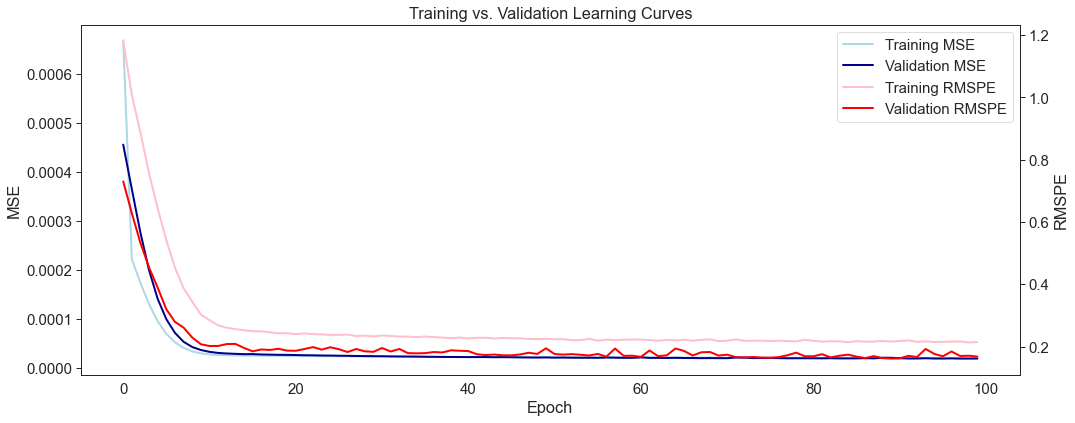

In [551]:
visualise_train_val_metrics(snn_1_res)

In [552]:
# FORECASTING ON VALIDATION SET
snn_1_preds = forecast(snn_1, val_idx, n_past)

In [553]:
# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
snn_1_preds_scaled = scale(scaler_vol, snn_1_preds)

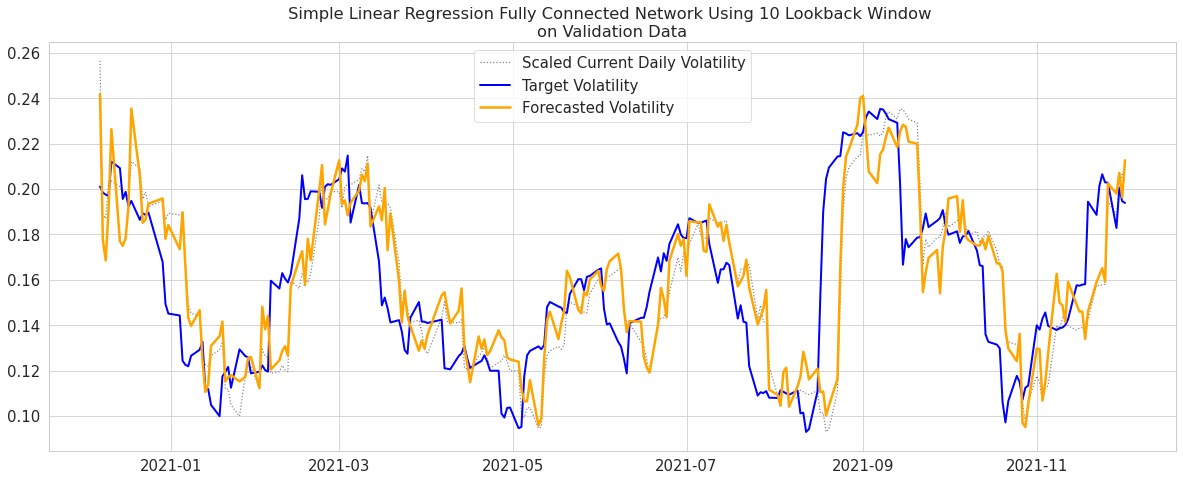

In [554]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
visualise_model(y_val_scaled, snn_1_preds_scaled, 
          f"Simple Linear Regression Fully Connected Network Using {n_past} Lookback Window")
plt.show();

The forecast is tracing the current volatility line well, but is mostly lagging behind compared to my target values.

In [555]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.331782   
1                           Random Walk Naive Forecasting          0.173708   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.434597   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.403040   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.198465   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.198495   
6     Bootstrap TARCH(1, 1, 0), Constant Mean, Skewt Dist          0.185543   
7                 Simple LR Fully Connected NN, n_past=10          0.171135   

   Validation RMSE  
0         0.040707  
1         0.026888  
2         0.069829  
3         0.066940  
4         0.036207  
5         0.036242  
6         0.032932  
7         0.025757

A simple Fully Connected NN doesn't perform too bad. Validation RMSPE after 100 epochs of training and barely any tuning is already lower than best GARCH model's RMSPE, and actually lower on RMSE. Validation RMSE a little lower than random walk naive forecasting, however validation RMSPE slightly higher.

# 4.2. Univariate Long Short-Term Memory (LSTM)


At each time step `t`, the recurrent neuron receives input as well as its own output from the previous time step. Since the output of a Recurrent Neuron is a function of all the inputs from the previous time steps, it has a form of memory and able to preserve some information through time.

However, due to some transformations that the data goes through when traversing down RNN, some information is lost at each time step, and for a long sequence, the RNN's state contains virtually no information from the first inputs.

Long Short-Term Memory (LSTM) was proposed in 1997 by Sepp Hochreiter and Jurgen Schmidhuber. The key part of LSTM is that the network can learn what's important and needs to be stored in the long-term state, and what can be ignored. LSTM looks very similar to a regular RNN cell, but its state is split into 2 vectors:

 - for short term state
 - for long term state
LSTM is a black box, and can be used like a basic Recurrent Neural Network (RNN) cell. However, it tends to perform much better, helps training converge faster, and also detect long-term dependencies in the data.

First, I'm going to use the same lookback window `n_past` as the previous Neural Networks (5), and then depending on the result, I'll try to fine tune that value later.

The first LSTM model would be very simple with only 1 hidden LSTM layer of 20 units. I am using the standard adam optimizer here, and would later experiment with other optimizers if needed.

In [556]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 10
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
None


In [557]:
# FIT TO TRAINING DATA
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

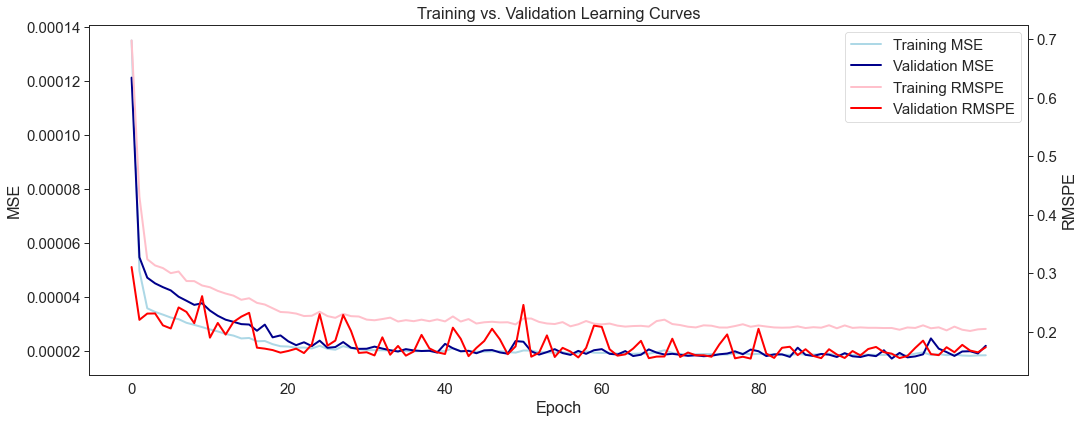

In [558]:
# VISUALISE TRAINING VS. VALIDATION LOSS METRICS
visualise_train_val_metrics(lstm_1_res)

Validation RMSPE looks quiet unstable, but we will still test this model

In [559]:
# FORECASTING ON VALIDATION SET
lstm_1_preds = forecast(lstm_1, val_idx, n_past)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)

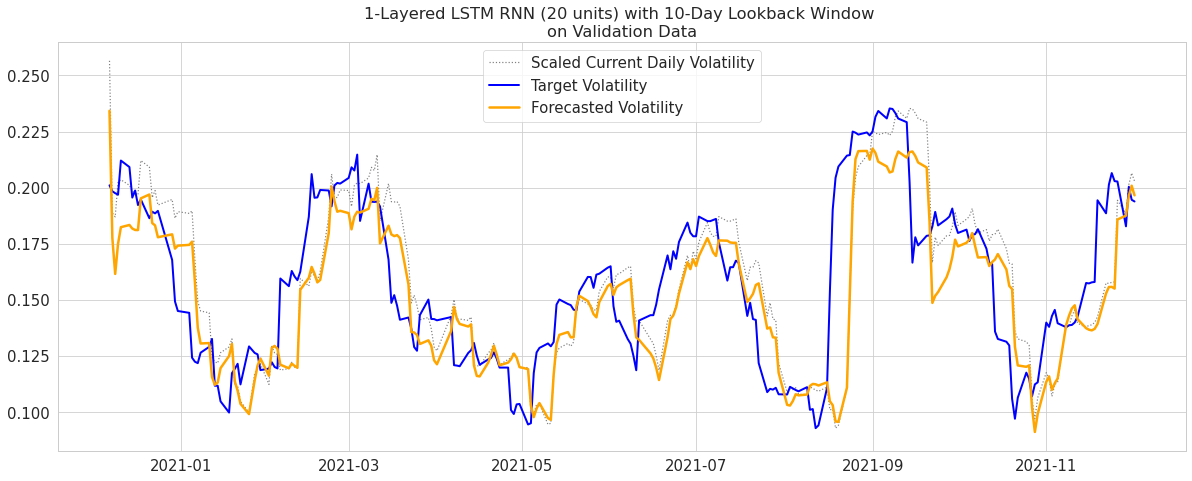

In [560]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
visualise_model(y_val_scaled, lstm_1_preds_scaled, 
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")
plt.show();

Again, predictions traces `vol_current` quite closely, but still lagging behind the target

In [561]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_1_preds_scaled, 
         f"LSTM 1 layer 20 units, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.331782   
1                           Random Walk Naive Forecasting          0.173708   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.434597   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.403040   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.198465   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.198495   
6     Bootstrap TARCH(1, 1, 0), Constant Mean, Skewt Dist          0.185543   
7                 Simple LR Fully Connected NN, n_past=10          0.171135   
8                        LSTM 1 layer 20 units, n_past=10          0.155522   

   Validation RMSE  
0         0.040707  
1         0.026888  
2         0.069829  
3         0.066940  
4         0.036207  
5         0.036242  
6         0.032932  
7         0.025757  
8         0.025093

1-layered LSTM is a bit better than fully connected network on RMSPE and RMSE

# 4.3. Univariate Bidirectional LSTM

(Reference: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/#:~:text=Bidirectional%20LSTMs%20are%20an%20extension,LSTMs%20on%20the%20input%20sequence)

Further research shows that there's an extension of LSTM cell called Bidirectional LSTM, which could potentially be better in this case by providing additional context to the models. Since all timesteps of the input sequence are already available, Bidirectional LSTM could train 2 instead of 1 LSTMs on the same input sequence:

1st one on the inputs as-is
2nd one on the reversed copy of the inputs
This could help provide additional context to the networks, and usually produces faster and fuller learning on the problem.

LSTM allows the maintenance of certain long-term memories across time, therefore I'll extend `n_past` to 1 month, and also increase the number of hidden layers to see if the model can capture certain patterns better.

In [562]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

# INCREASING LOOKBACK WINDOW TO 1 MONTH
n_past = 20
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 19,105
Trainable params: 19,105
Non-trainable params: 0
_________________________________________________________________
None


In [563]:
# FITTING lstm_2 TO TRAINING DATA
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

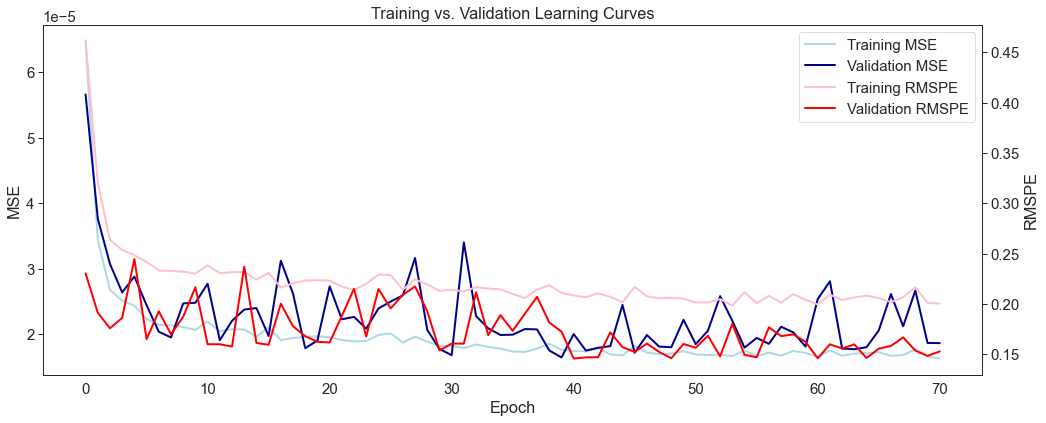

In [564]:
# VISUALIZING PERFORMANCE METRICS
visualise_train_val_metrics(lstm_2_res)

In [565]:
def visualise_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

In [566]:
# FORECASTING ON VALIDATION SET
lstm_2_preds = forecast(lstm_2, val_idx, n_past)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_2_preds_scaled = scale(scaler_vol, lstm_2_preds)

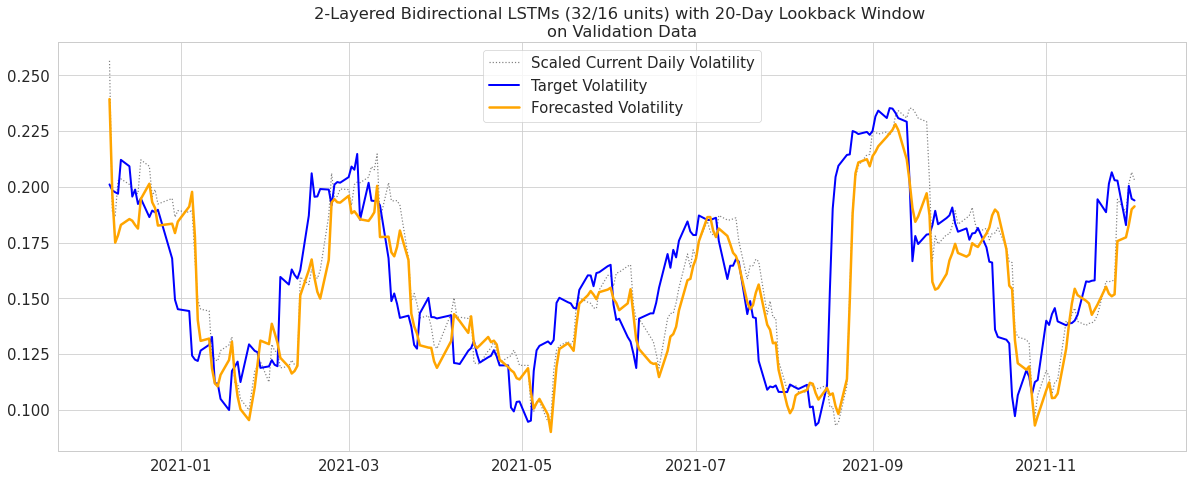

In [567]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
visualise_model(y_val_scaled, lstm_2_preds_scaled, 
          f"2-Layered Bidirectional LSTMs (32/16 units) with {n_past}-Day Lookback Window")
plt.show();

In [568]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_2_preds_scaled, 
         f"2 layers Bidirect LSTM (32/16 units), n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.331782   
1                           Random Walk Naive Forecasting          0.173708   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.434597   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.403040   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.198465   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.198495   
6     Bootstrap TARCH(1, 1, 0), Constant Mean, Skewt Dist          0.185543   
7                 Simple LR Fully Connected NN, n_past=10          0.171135   
8                        LSTM 1 layer 20 units, n_past=10          0.155522   
9         2 layers Bidirect LSTM (32/16 units), n_past=20          0.161432   

   Validation RMSE  
0         0.040707  
1         0.026888  
2         0.069829  
3         0.066940  
4         0.036207  
5         0.036242  
6         0.032932  
7         0.025757  
8         0.025093  
9         0.025559

Validaton RMSE lower than 1 layer LSTM, but validation RMSPE slightly higher

# 4.4. Univariate Bidirectional LSTM + 1D Convolutional Layer(s)

(Reference: Geron (2019))

A 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel. Each kernel will learn to detect a single very short sequential pattern (no longer than the kernel size).

Convolutional layers are supposed to allow lookback window extension, and help the model pick up patterns further in the past.

In [569]:
# Ref: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 20
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),
    # ADDING 1D CONVOLUTIONAL LAYER 
    tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                           # DOWNSAMPLE INPUT SEQUENCE BY A FACTOR OF 2
                           strides=2, padding="valid",    
                           activation="relu",
                           input_shape=[None, 1]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                       return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_3.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_3.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')
print(lstm_3.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          160       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 27,201
Trainable params: 27,201
Non-trainable params: 0
_________________________________________________________________
None


In [570]:
# FITTING MODEL TO TRAINING DATA
lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

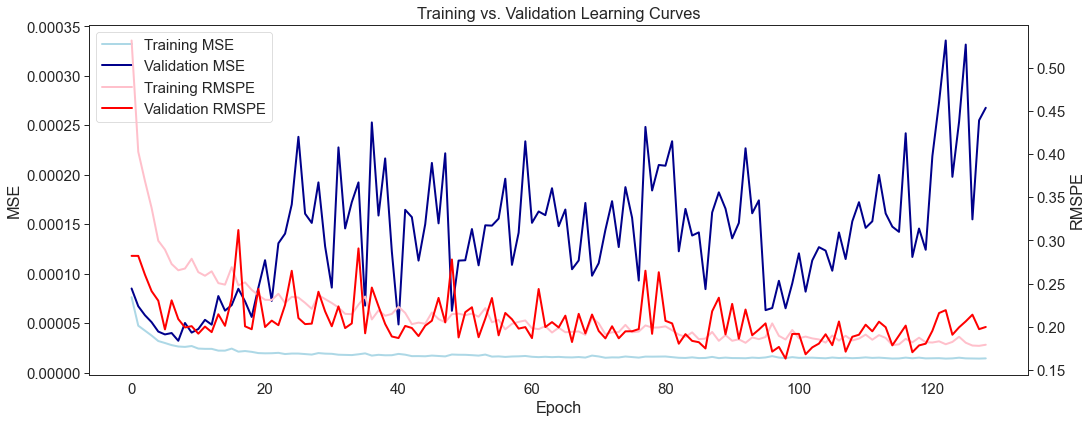

In [571]:
# VISUALISING TRAINING/VALIDATION METRICS
visualise_train_val_metrics(lstm_3_res)

In [572]:
# FORECASTING ON VALIDATION SET
lstm_3_preds = forecast(lstm_3, val_idx, n_past)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_3_preds_scaled = scale(scaler_vol, lstm_3_preds)

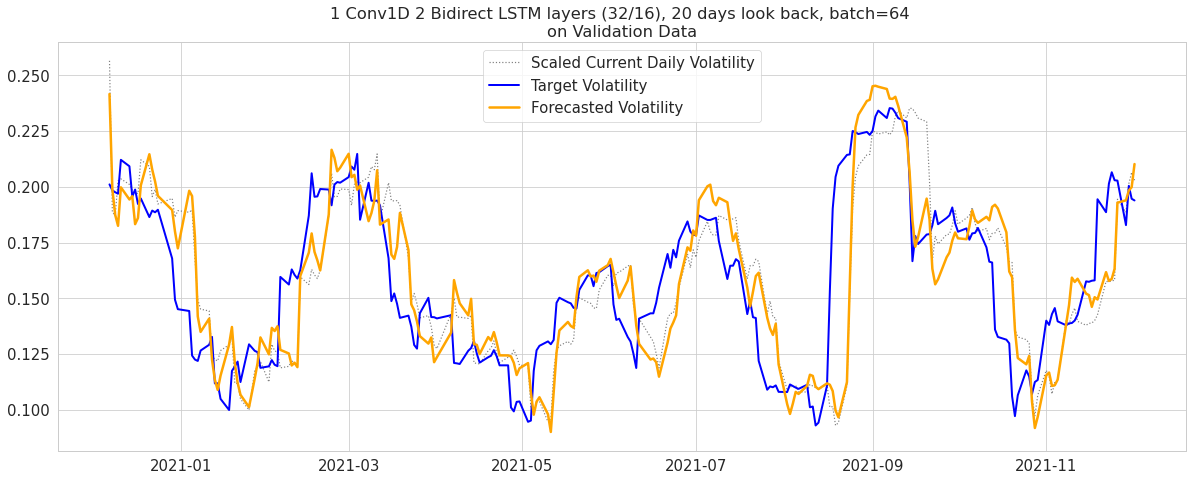

In [573]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
visualise_model(y_val_scaled, lstm_3_preds_scaled, 
          f"1 Conv1D 2 Bidirect LSTM layers (32/16), {n_past} days look back, batch={batch_size}")
plt.show();

In [574]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_3_preds_scaled, 
         f"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past={n_past}, batch={batch_size}")

Model  \
0                                                  Mean Baseline   
1                                  Random Walk Naive Forecasting   
2                         GARCH(1,1), Constant Mean, Normal Dist   
3         Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5               Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6            Bootstrap TARCH(1, 1, 0), Constant Mean, Skewt Dist   
7                        Simple LR Fully Connected NN, n_past=10   
8                               LSTM 1 layer 20 units, n_past=10   
9                2 layers Bidirect LSTM (32/16 units), n_past=20   
10  1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=20, batch=64   

    Validation RMSPE  Validation RMSE  
0           0.331782         0.040707  
1           0.173708         0.026888  
2           0.434597         0.069829  
3           0.403040         0.066940  
4           0.198465         0.036207  
5           0.198495         0.036242  
6           0.185543         0.032932  
7           0.171135         0.025757  
8           0.155522         0.025093  
9           0.161432         0.025559  
10          0.163564         0.024906

So Convolutional layers increase RMSPE and RMSE, and the performance is somewhat on par with simple LR fully connected NN.

### 4.5. Learning Rate Tuning with SGD Optimizer

So far I have only used the standard `adam` optimizer. It'd be interesting to see how the model performs on a more customizable optimizer like **Stochastic Gradient Descent (SGD)**. I will continue this with the most successful LSTM architecture so far (2 layers of Bidirectional LSTMs with 32 and 16 units and a lookback window of 20 days).

In [575]:
# Ref: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 20
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

# EXPONENTIALLY INCREASE LEARNING RATE 
# BY THE POWER OF 10 EVERY 20 EPOCHS
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
lstm_4.compile(loss='mse',
               optimizer=optimizer,
               metrics=[rmspe])

lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, epochs=160,
                        callbacks=[lr_schedule],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

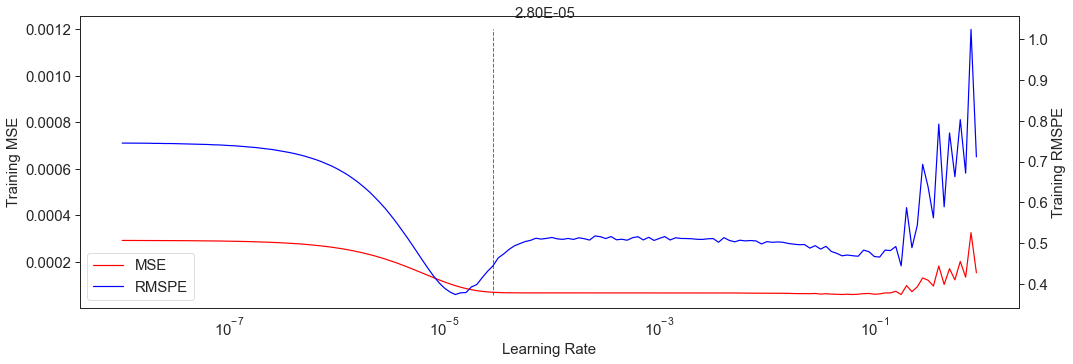

In [576]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(15,5))

    # PLOT MSE - LEFT Y-AXIS
    ln1 = ax.semilogx(lstm_4_res.history['lr'], lstm_4_res.history['loss'], 
                color='red', label='MSE')
    ax.set_xlabel('Learning Rate', fontsize=15)
    ax.set_ylabel('Training MSE', fontsize=15)

    # PLOT RMSE - RIGHT Y-AXIS
    ax2 = ax.twinx()
    ln2 = ax2.semilogx(lstm_4_res.history['lr'], lstm_4_res.history['rmspe'],
                color='blue', label='RMSPE')
    ax2.set_ylabel('Training RMSPE', fontsize=15)

    # COMBINING LALBELS FOR 2 LINES INTO 1 LEGEND
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='lower left')

    best_lr = 2.8e-5

    ax.vlines(x=best_lr, ls='--', lw=1,
            ymin=np.min(lstm_4_res.history["loss"]),
            ymax=0.0012)

    ax.text(4.5e-5, 0.00125, '%.2E' % Decimal(best_lr), fontsize=15)

    plt.show();

The best learning rate would likely be `2.8e-5` which is the intersection between the RMSE and RMSPE lines. RMSE continues to go down, but RMSPE started going up and gets very unstable quickly after. Next I am going to re-train the model using the best learning rate found above.

Automating this `best_lr` rather than looking at graph

In [577]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 20
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=best_lr, momentum=0.9)
lstm_4.compile(loss='mse',
               optimizer=optimizer,
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_4.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

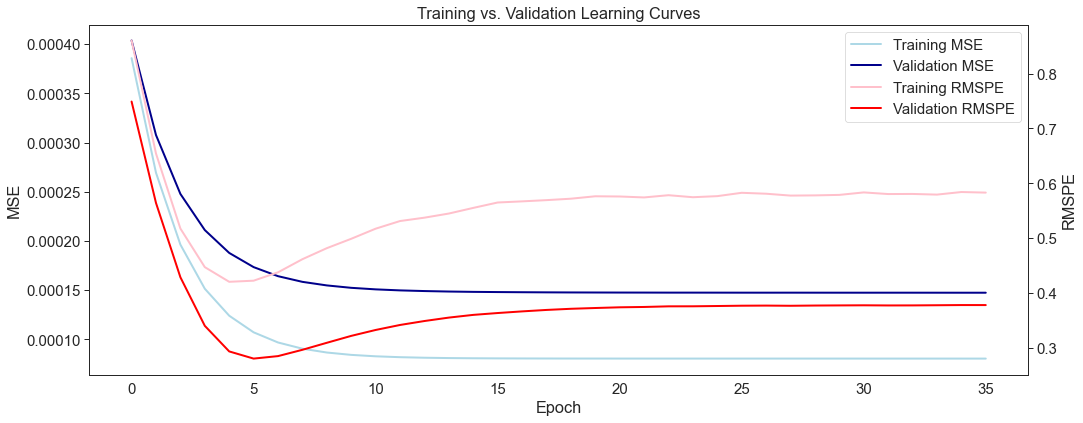

In [578]:
# VISUALISING TRAINING/VALIDATION LEARNING CURVES
visualise_train_val_metrics(lstm_4_res)

Training RMSPE started going up after epoch 7, Validation RMSPE not increase as much as training, while RMSE continued going down over the epochs. Performance stopped progressing between 15-30ish.

In [579]:
# FORECASTING ON VALIDATION SET
lstm_4_preds = forecast(lstm_4, val_idx, n_past)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_4_preds_scaled = scale(scaler_vol, lstm_4_preds)

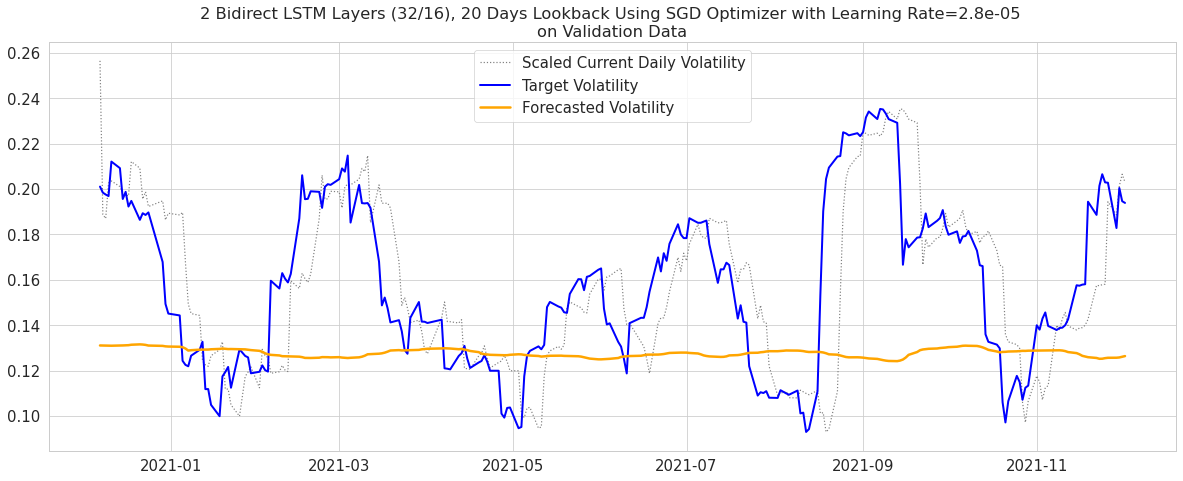

In [580]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
visualise_model(y_val_scaled, lstm_4_preds_scaled, 
          f"2 Bidirect LSTM Layers (32/16), {n_past} Days Lookback Using SGD Optimizer with Learning Rate={best_lr}")
plt.show();

This customised SGD optimiser seems to prioritise volatility's long-term tendency to revert to the mean. Hence the predictions hovers where the mean is.

The settings for `SGD` optimiser using best learning rate found above did not seem to yield better results than the `adam` optimiser, so lets stick with `adam`.

In [581]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_4_preds_scaled, 
         f"2 Bidirect LSTMs (32/16), n_past={n_past}, batch={batch_size}, SGD lr={best_lr}")

Model  \
0                                                   Mean Baseline   
1                                   Random Walk Naive Forecasting   
2                          GARCH(1,1), Constant Mean, Normal Dist   
3          Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                 Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6             Bootstrap TARCH(1, 1, 0), Constant Mean, Skewt Dist   
7                         Simple LR Fully Connected NN, n_past=10   
8                                LSTM 1 layer 20 units, n_past=10   
9                 2 layers Bidirect LSTM (32/16 units), n_past=20   
10   1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=20, batch=64   
11  2 Bidirect LSTMs (32/16), n_past=20, batch=64, SGD lr=2.8e-05   

    Validation RMSPE  Validation RMSE  
0           0.331782         0.040707  
1           0.173708         0.026888  
2           0.434597         0.069829  
3           0.403040         0.066940  
4           0.198465         0.036207  
5           0.198495         0.036242  
6           0.185543         0.032932  
7           0.171135         0.025757  
8           0.155522         0.025093  
9           0.161432         0.025559  
10          0.163564         0.024906  
11          0.250049         0.047287

# 4.6 Test multivariate LSTM

So far I have only using simple 1-dimensional inputs for all of my models, and for financial data, this is likely insufficient. That could be the reason why most of the above models seems failed to yield better result than Naive Forecasting. It doesn't matter how many neurons or hidden layers are used, or how complex the model's architectures are, inadequate data is most likely not going to produce good results.

For the next section, I'll attempt to create Multivariate Neural Networks to see if additional features could help improve performance.

In [582]:
qantas[['conm', 'adj_price', 'open_adj_price', 'adj_high_price', 'adj_low_price', 'volume', 'mcap_comp']].head()

conm  adj_price  open_adj_price  adj_high_price  \
date                                                                        
1996-10-02  QANTAS AIRWAYS LTD   2.140575        2.066028        2.183174   
1996-10-04  QANTAS AIRWAYS LTD   2.097977        2.108626        2.108626   
1996-10-08  QANTAS AIRWAYS LTD   2.119276        2.087327        2.129925   
1996-10-09  QANTAS AIRWAYS LTD   2.119276        2.119276        2.140575   
1996-10-10  QANTAS AIRWAYS LTD   2.119276        2.119276        2.119276   

            adj_low_price     volume     mcap_comp  
date                                                
1996-10-02       2.097977  1468361.0  2.216482e+09  
1996-10-04       2.076677  1092109.0  2.172373e+09  
1996-10-08       2.066028  1001171.0  2.194428e+09  
1996-10-09       2.097977  2823990.0  2.194428e+09  
1996-10-10       2.097977  1044604.0  2.194428e+09

In [583]:
qantas[['conm', 'adj_price', 'open_adj_price', 'adj_high_price', 'adj_low_price', 'volume', 'mcap_comp']].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6334 entries, 1996-10-02 to 2022-01-04
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   conm            6334 non-null   object 
 1   adj_price       6334 non-null   float64
 2   open_adj_price  6334 non-null   float64
 3   adj_high_price  6334 non-null   float64
 4   adj_low_price   6334 non-null   float64
 5   volume          6334 non-null   float64
 6   mcap_comp       6334 non-null   float64
dtypes: float64(6), object(1)
memory usage: 653.9+ KB


In [584]:
qantas[['conm', 'adj_price','open_adj_price', 'adj_high_price', 'adj_low_price', 'volume', 'mcap_comp']].corr()


adj_price  open_adj_price  adj_high_price  adj_low_price  \
adj_price        1.000000        0.998490        0.999524       0.999546   
open_adj_price   0.998490        1.000000        0.998932       0.998896   
adj_high_price   0.999524        0.998932        1.000000       0.999290   
adj_low_price    0.999546        0.998896        0.999290       1.000000   
volume          -0.012378       -0.012574       -0.007505      -0.016292   
mcap_comp        0.881853        0.880261        0.881167       0.882199   

                  volume  mcap_comp  
adj_price      -0.012378   0.881853  
open_adj_price -0.012574   0.880261  
adj_high_price -0.007505   0.881167  
adj_low_price  -0.016292   0.882199  
volume          1.000000   0.139638  
mcap_comp       0.139638   1.000000

#### 4.6.1. Feature Engineering

The `adj_price`(Close)/`open_adj_price`(Open)/`adj_high_price`(High)/`adj_low_price`(Low) prices are usually very similar and highly correlated to each other. Therefore, instead of keeping all of them in the dataset, I would add 2 more features:
- **High-Low Spread** - log of the difference between the Highest and Lowest prices intraday as a percentage of the Closing price
- **Open-Close Spread** - which is the difference between the Close and Open prices intraday as a percentage of the Closing price

and then for `volume`:
- Volume column has very large values that are millions of times larger than the other features. Therefore I'm going to the get `np.log()` of it, and hopefully transform it into a more normal looking distribution.

and eliminate the three `Close`, `Open`, `High`, `Low` columns.

we will see if `mcap_comp` is highly correlated to any of these, if not, will use `np.log()` of it.

In [603]:
qantas['HL_sprd'] = np.log((qantas.adj_high_price - qantas.adj_low_price) / qantas.adj_price)
qantas['CO_sprd'] = (qantas.open_adj_price - qantas.adj_price) / qantas.adj_price
qantas['volume'] = np.log(qantas.volume)
qantas['mcap'] = np.log(qantas.mcap_comp)

In [604]:
qantas[['HL_sprd', 'CO_sprd', 'volume', 'mcap', 'vol_current']].corr()

HL_sprd   CO_sprd    volume      mcap  vol_current
HL_sprd      1.000000  0.036777  0.275811 -0.182834     0.499991
CO_sprd      0.036777  1.000000  0.001268 -0.027298     0.017462
volume       0.275811  0.001268  1.000000  0.282563     0.185189
mcap        -0.182834 -0.027298  0.282563  1.000000    -0.250446
vol_current  0.499991  0.017462  0.185189 -0.250446     1.000000

In [605]:
features = ['HL_sprd', 'CO_sprd','volume','mcap', 'vol_current']

These numeric features will need to be normalised later since LSTM uses `sigmoid` and `tanh` activation functions, which is very sensitive magnitude.

Since `vol_current` is already derived from `log_returns`, I am not going to include `log_returns` in the model.

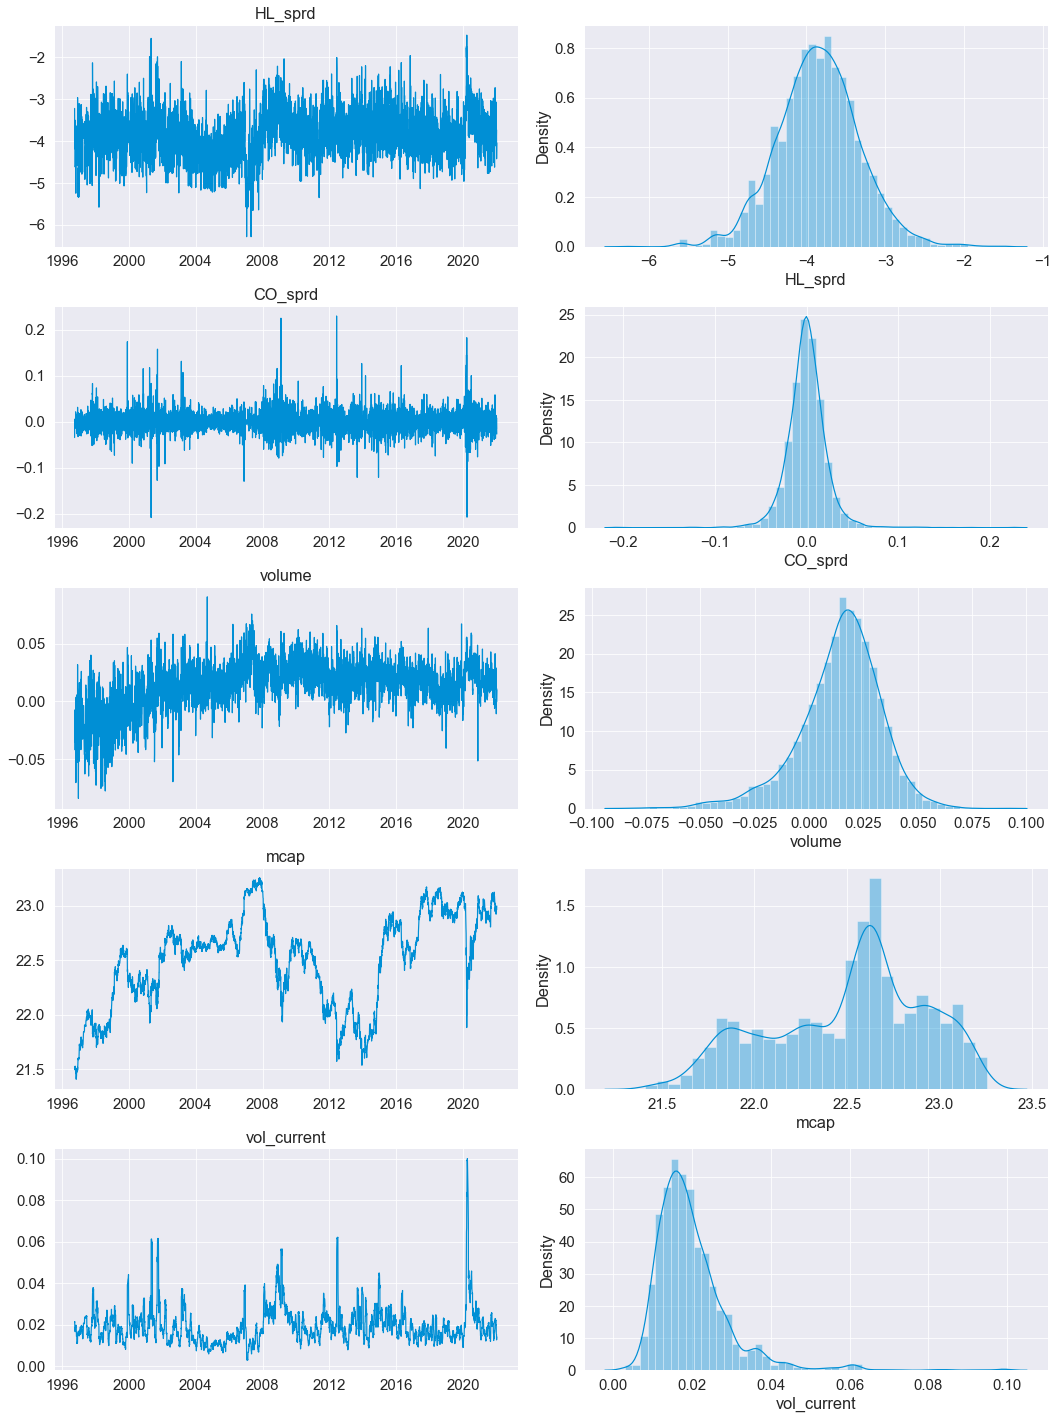

In [606]:
# PLOT EACH NUMERICAL COLUMN
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,20))

    for i, c in enumerate(features):
        ax1, ax2 = axes[i][0], axes[i][1]
        ax1.plot(qantas[c])
        ax1.set_title(c)

        sns.distplot(qantas[c], ax=ax2)

    plt.tight_layout()
    plt.show();

The predict here would be to predict next 5 days' volatility (`vol_future`) column using 5 input variables:
1. `HL_sprd`
2. `CO_sprd`
3. `Volume`
4. `vol_current`
5. `mcap`

Reshaping the inputs is the meat of these Multivariate LSTM. Generally speaking, inputs for LSTM should be in the shape of:


**`[batch_size, n_past, input_dims]`**



in which:

- **`batch_size`** is the number of datapoints in each batch
- **`n_past`** is the number of past time steps to be used for prediction (I'll use the same value as above for now).
- **`input_dims`** is the number of input features (which is 5 in this case)  

In [607]:
# SEPARATE INPUT DATAFRAME FROM qantas df
input_df = qantas[features]

# SEPARATE INPUTS FOR TRAINING SET ONLY
X_train = input_df.loc[train_idx]

X_train.head()

HL_sprd   CO_sprd    volume       mcap  vol_current
date                                                            
1996-10-02 -3.223863 -0.034826 -0.024525  21.519187     0.021007
1996-10-04 -4.184591  0.005076 -0.032729  21.499086     0.021507
1996-10-08 -3.501545 -0.015075 -0.035197  21.509187     0.017156
1996-10-09 -3.907010  0.000000 -0.007425  21.509187     0.016812
1996-10-10 -4.600158  0.000000 -0.033988  21.509187     0.016653

In [608]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6062 entries, 1996-10-02 to 2020-12-04
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      6062 non-null   float64
 1   CO_sprd      6062 non-null   float64
 2   volume       6062 non-null   float64
 3   mcap         6062 non-null   float64
 4   vol_current  6062 non-null   float64
dtypes: float64(5)
memory usage: 413.2 KB


In [609]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6334 entries, 1996-10-02 to 2022-01-04
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      6334 non-null   float64
 1   CO_sprd      6334 non-null   float64
 2   volume       6334 non-null   float64
 3   mcap         6334 non-null   float64
 4   vol_current  6334 non-null   float64
dtypes: float64(5)
memory usage: 554.9 KB


In [615]:
def forecast_multi(model, range_idx, n_past, equities=True):
    if equities == True:
        #have to offset by business days, as trades don't occur on the weekend
        bd = pd.tseries.offsets.BusinessDay(n = (n_past-1))
        start_idx = range_idx[0] - bd
    else:
        #markets that trade on the weekend (e.g., currencies or crypto)
        start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(input_df[start_idx:end_idx], 
                                qantas.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

### 4.7. Multivariate 2-Layered Bidirectional LSTM with Dropout

The first Multivariate LSTM model would be 2 hidden layers of Bidirectional LSTM (quite similar to the Univariate structure above). However, I will also include Dropout layers in between. Having more features means the model would be more prone to **overfitting**, and Dropout layers can help reduce that.

In [611]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 20
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_5 = tf.keras.models.Sequential([ 
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_5.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_5.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 20, 5)             20        
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 64)            9728      
_________________________________________________________________
dropout (Dropout)            (None, 20, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 20,149
Trainable params: 20,139
Non-trainable params: 10
___________________________________________________

In [612]:
# FITTING TO TRAINING DATA
lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

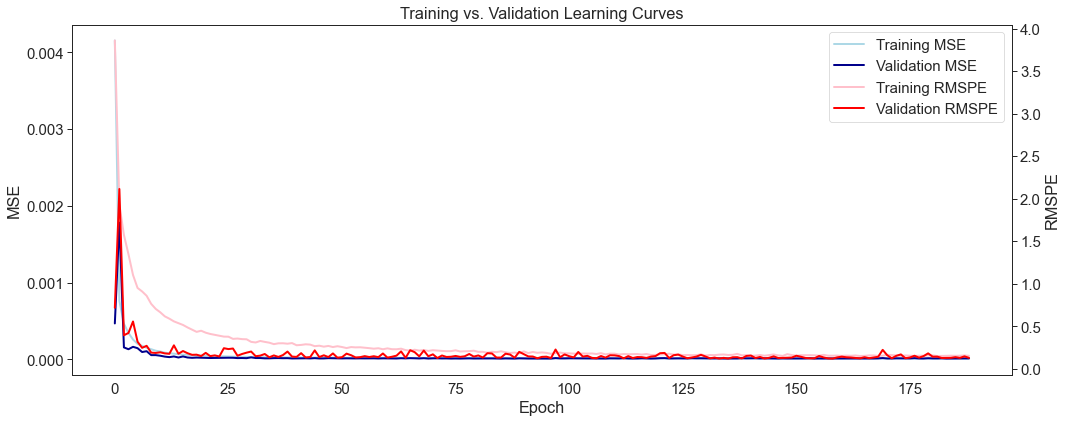

In [613]:
# VISUALISING LEARNING CURVES
visualise_train_val_metrics(lstm_5_res)

In [616]:
# FORECASTING ON VALIDATION SET
lstm_5_preds = forecast_multi(lstm_5, val_idx, n_past)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_5_preds_scaled = scale(scaler_vol, lstm_5_preds)

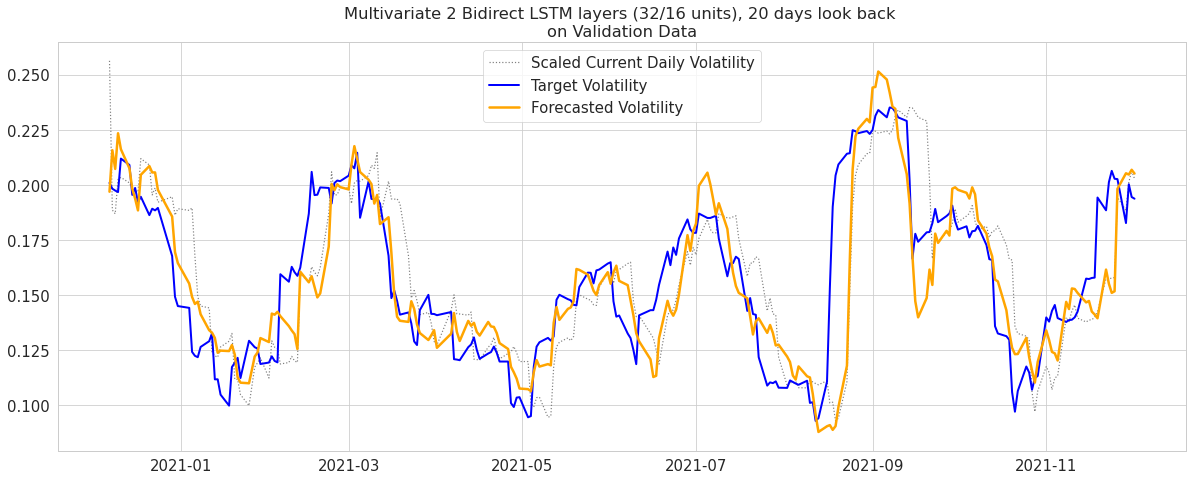

In [617]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
visualise_model(y_val_scaled, lstm_5_preds_scaled, 
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back")
plt.show();

In [618]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_5_preds_scaled,
         f"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past={n_past}")

Model  \
0                                                   Mean Baseline   
1                                   Random Walk Naive Forecasting   
2                          GARCH(1,1), Constant Mean, Normal Dist   
3          Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                 Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6             Bootstrap TARCH(1, 1, 0), Constant Mean, Skewt Dist   
7                         Simple LR Fully Connected NN, n_past=10   
8                                LSTM 1 layer 20 units, n_past=10   
9                 2 layers Bidirect LSTM (32/16 units), n_past=20   
10   1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=20, batch=64   
11  2 Bidirect LSTMs (32/16), n_past=20, batch=64, SGD lr=2.8e-05   
12   Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=20   

    Validation RMSPE  Validation RMSE  
0           0.331782         0.040707  
1           0.173708         0.026888  
2           0.434597         0.069829  
3           0.403040         0.066940  
4           0.198465         0.036207  
5           0.198495         0.036242  
6           0.185543         0.032932  
7           0.171135         0.025757  
8           0.155522         0.025093  
9           0.161432         0.025559  
10          0.163564         0.024906  
11          0.250049         0.047287  
12          0.130602         0.022027

# Sort models by performance


In [619]:
perf_df.sort_values(by='Validation RMSPE', ascending=True)

Model  \
12   Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=20   
8                                LSTM 1 layer 20 units, n_past=10   
9                 2 layers Bidirect LSTM (32/16 units), n_past=20   
10   1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=20, batch=64   
7                         Simple LR Fully Connected NN, n_past=10   
1                                   Random Walk Naive Forecasting   
6             Bootstrap TARCH(1, 1, 0), Constant Mean, Skewt Dist   
4                 Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                Simulation TARCH(1,1), Constant Mean, Skewt Dist   
11  2 Bidirect LSTMs (32/16), n_past=20, batch=64, SGD lr=2.8e-05   
0                                                   Mean Baseline   
3          Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
2                          GARCH(1,1), Constant Mean, Normal Dist   

    Validation RMSPE  Validation RMSE  
12          0.130602         0.022027  
8           0.155522         0.025093  
9           0.161432         0.025559  
10          0.163564         0.024906  
7           0.171135         0.025757  
1           0.173708         0.026888  
6           0.185543         0.032932  
4           0.198465         0.036207  
5           0.198495         0.036242  
11          0.250049         0.047287  
0           0.331782         0.040707  
3           0.403040         0.066940  
2           0.434597         0.069829

For this final model, I'll re-create the same architecture as model #12 (Multivariate Bidirectional LSTM with 2 layers of 32/16 units) and a lookback window `n_past` = 20 and `batch_size` = 64. However, I'll extend the training to include the validation set as well. This is important in time series data since the more recent time steps would most likely carry more relevant information for successful forecasting than data from a year ago.

Since the validation MSE and RMSPE lines have been very unstable, I will extend the training epochs to 500 to seee if that could help capture better weights.

In [620]:
# CREATE DATASET THAT COMBINES BOTH TRAINING & VALIDATION
tv_df = input_df[:split_time_2]
tv_y = qantas.vol_future[:split_time_2]

In [621]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 20
batch_size = 64
n_dims = input_df.shape[1]

mat_X_tv, mat_y_tv = windowed_dataset(tv_df, tv_y, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_final = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),   
    # BATCH NORMALIZATION  
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_final.compile(loss='mse', 
                    optimizer="adam", 
                    metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_final.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_final.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 20, 5)             20        
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 64)            9728      
_________________________________________________________________
dropout (Dropout)            (None, 20, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 20,149
Trainable params: 20,139
Non-trainable params: 10
___________________________________________________

In [622]:
lstm_final_res = lstm_final.fit(mat_X_tv, mat_y_tv, epochs=500,
                                validation_split=0.2,
                                callbacks=[checkpoint_cb, early_stopping_cb],
                                verbose=0, batch_size=batch_size, shuffle=True)

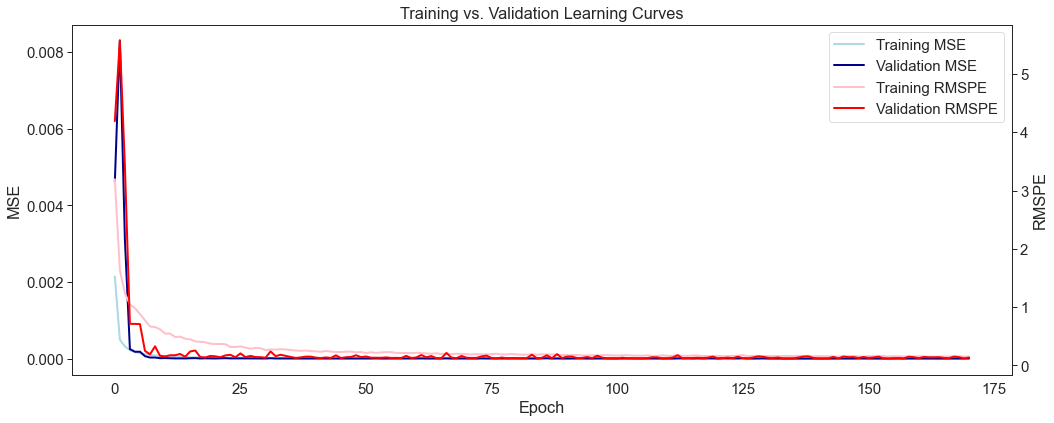

In [623]:
visualise_train_val_metrics(lstm_final_res)

### Final Model's Predictions on Test Set

In [624]:
# FORECASTING ON VALIDATION SET
y_test_preds = forecast_multi(lstm_final, test_idx, n_past)

In [625]:
y_test_preds.describe()

count    20.000000
mean      0.018855
std       0.003357
min       0.013291
25%       0.016277
50%       0.019128
75%       0.022078
max       0.023482
dtype: float64

In [626]:
y_test.describe()

count    20.000000
mean      0.017483
std       0.004036
min       0.012052
25%       0.013977
50%       0.017736
75%       0.021979
max       0.022174
Name: vol_future, dtype: float64

In [627]:
# GETTING DAILY VOLATILITY QUANTILES
q1 = qantas.vol_current[:split_time_2].describe()['25%']

q2 = qantas.vol_current[:split_time_2].describe()['50%']

q3 = qantas.vol_current[:split_time_2].describe()['75%']

In [628]:
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

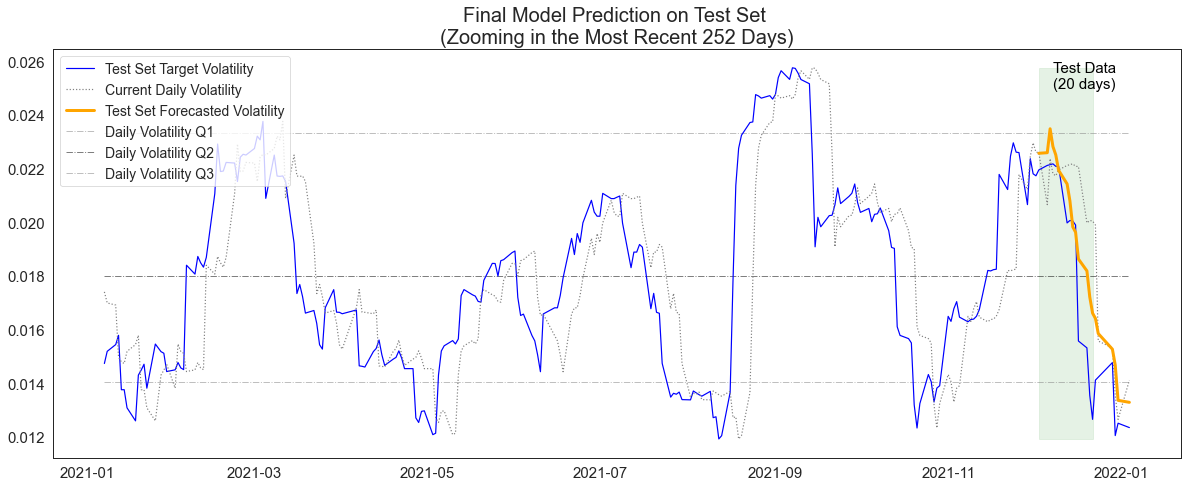

In [647]:
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib

# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 252

    ax1.plot(qantas.vol_future[-n_display:], color='blue', 
                label=f"Test Set Target Volatility")
    ax1.plot(qantas.vol_current[-n_display:], color='gray',  ls=':',
                label=f"Current Daily Volatility")
    ax1.plot(y_test_preds, color='orange', lw=3,
                label=f'Test Set Forecasted Volatility')
    
    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q, color=q_colors[i], alpha=0.5, label=f'Daily Volatility Q{i+1}', ls='-.', lw=1,
                    xmin=qantas.vol_future[-n_display:].index[0],
                    xmax=qantas.vol_future[-n_display:].index[-1])
        
    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA    
    w = len(test_idx) - 1 
    h = qantas.vol_future[-n_display:].max() - qantas.vol_future[-n_display:].min()
    x0 = mdates.date2num(qantas.index[split_time_2])
    y0 = qantas.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(qantas.index[(split_time_2 + 3)], 0.025, 
             'Test Data\n(20 days)', 
             fontsize=15, color='black')

    plt.title(f'Final Model Prediction on Test Set \n(Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.show();

In [632]:
# GENERATING PREDICTIONS ON THE WHOLE DATASET (7 years)
mat_X_all, _ = windowed_dataset(input_df, qantas.vol_future, n_past)
preds_all = pd.Series(lstm_final.predict(mat_X_all)[:,0], 
                      index=qantas.index[-(mat_X_all).shape[0]:])

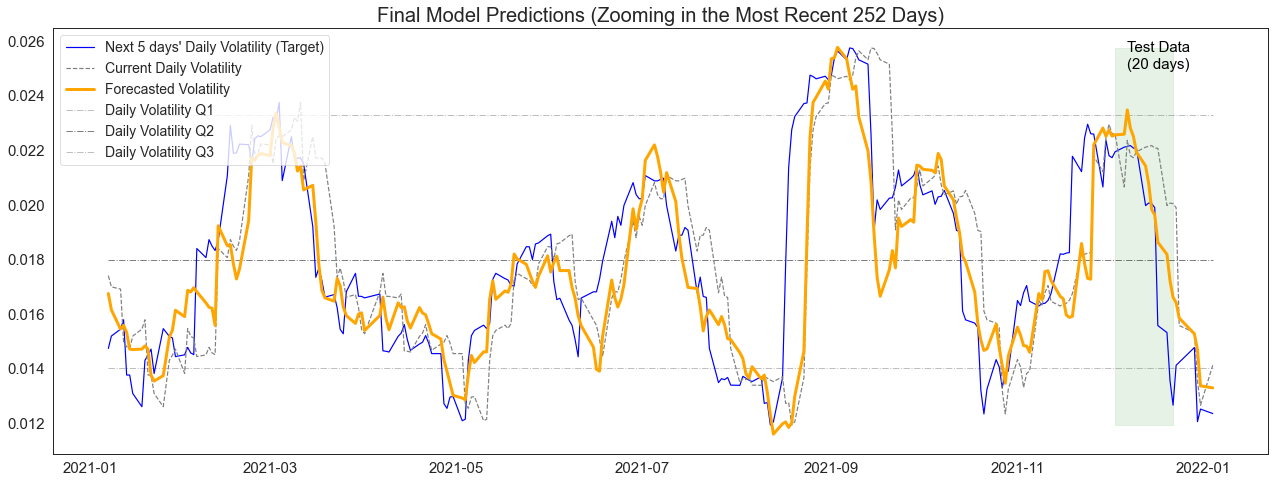

In [648]:
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 252

    ax1.plot(qantas.vol_future[-n_display:], color='blue', 
                label=f"Next {n_future} days' Daily Volatility (Target)")
    ax1.plot(qantas.vol_current[-n_display:], color='gray',  ls='--',
                label=f"Current Daily Volatility")
    ax1.plot(preds_all[-n_display:], color='orange', lw=3,
                label=f'Forecasted Volatility')

    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q,
                   xmin=qantas.vol_future[-n_display:].index[0],
                   xmax=qantas.vol_future[-n_display:].index[-1],
                   label=f'Daily Volatility Q{i+1}',
                   ls='-.', lw=1, color=q_colors[i], alpha=0.5)
    
    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA    
    w = len(test_idx) - 1 
    h = qantas.vol_future[-n_display:].max() - qantas.vol_future[-n_display:].min()
    x0 = mdates.date2num(qantas.index[split_time_2])
    y0 = qantas.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(qantas.index[(split_time_2 + 2)], 0.025, 
             'Test Data\n(20 days)', 
             fontsize=15, color='black')

    plt.title(f'Final Model Predictions (Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.show();

In [649]:
print('RMSPE on Test Set:', RMSPE(y_test, y_test_preds))

RMSPE on Test Set: 0.13342861640164508


In [650]:
1-RMSPE(y_test, y_test_preds)

0.866571383598355